In [1]:
import os
from tqdm import tqdm
import pickle
import random
from typing import Tuple

import pandas as pd
import numpy as np
import scipy
from sklearn.metrics.pairwise import pairwise_kernels
import matplotlib.pyplot as plt
import networkx as nx

from metaspace import SMInstance
from anndata import AnnData
from metaspace2anndata import dataset_to_anndata
import scanpy as sc
import seaborn as sns
from molmass import Formula

import utils
from config import store_dir, data_dir, date_key, enrichment_dir
%load_ext autoreload
%autoreload 2

# Load data

In [2]:
store_dir

'/g/alexandr/tim/metaspace_evaluation/230201'

In [2]:
dss = pickle.load(open(os.path.join(store_dir, 'all_datasets.pickle'), "rb" ) )
results = pickle.load(open(os.path.join(store_dir, 'hmdb4_results.pickle'), "rb" ) )
hmdb_v4 = pd.read_csv(os.path.join(data_dir, 'databases/HMDB_v4.csv'), index_col=None).set_index('chemical_formula')
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [3]:
md = utils.make_metadata_dict(dss, results, only_results=True)
mdt = utils.clean_metadata_table(utils.metadata_dict_totable(md))

In [4]:
mdt['top_Organism'] = utils.top_feature_col(mdt['Organism'], top=10)
mdt['top_Condition'] = utils.top_feature_col(mdt['Condition'], top=10)
mdt['top_Organism_Part'] = utils.top_feature_col(mdt['Organism_Part'], top=15)
mdt['top_Polarity'] = utils.top_feature_col(mdt['Polarity'], top=10)
mdt['top_maldi_matrix'] = utils.top_feature_col(mdt['maldi_matrix'], top=8)
mdt['top_Group'] = utils.top_feature_col(mdt['Group'], top=10)

In [5]:
# adata = utils.make_ion_anndata(results, mdt, fdr_cutoff=0.5, only_onSample=True)

adata = utils.make_molecule_anndata(results, mdt, fdr_cutoff=0.2, only_onSample=True)
adata.var = adata.var.rename(columns={0: 'molecule'}).reset_index().set_index('molecule').drop(columns='index')

100%|██████████| 7443/7443 [00:10<00:00, 718.94it/s]


10865  features


100%|██████████| 7443/7443 [00:33<00:00, 221.19it/s]
/home/trose/projects/metaspace_evaluation/utils.py:186: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return AnnData(X=mol_data.to_numpy(), var=pd.DataFrame(mol_features), obs=mdt.loc[mol_data.index, :])
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [6]:
sc.pp.filter_genes(adata, min_cells=100) # 200
sc.pp.filter_cells(adata, min_genes=20) # 50
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.tl.pca(adata)
#sc.external.pp.bbknn(adata, batch_key='maldi_matrix', metric='euclidean', neighbors_within_batch=1)
sc.pp.neighbors(adata, metric='cosine')
sc.tl.umap(adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
adata

AnnData object with n_obs × n_vars = 4437 × 1631
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes'
    var: 'n_cells'
    uns: 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

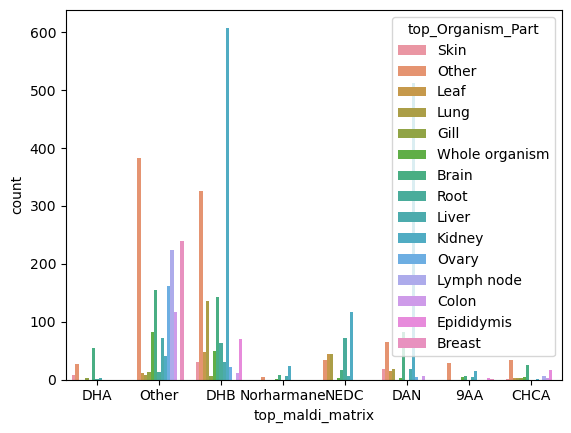

In [8]:
sns.countplot(data=adata.obs, x='top_maldi_matrix', hue='top_Organism_Part')

# Positive

In [9]:
adata_pos = adata[adata.obs['Polarity']=='Positive',:]

sc.pp.filter_genes(adata_pos, min_cells=100) # 200
sc.pp.filter_cells(adata_pos, min_genes=20) # 50
#sc.pp.normalize_total(adata_pos, target_sum=1e4)

#sc.pp.neighbors(adata_pos, metric='cosine')
#sc.tl.leiden(adata_pos)
#sc.tl.umap(adata_pos)

adata_pos.var['mass'] = [Formula(x).mass for x in adata_pos.var.index.values]

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [10]:
pd.DataFrame(adata_pos.var.index).to_csv(os.path.join(enrichment_dir, f'bg_pos.csv'))

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

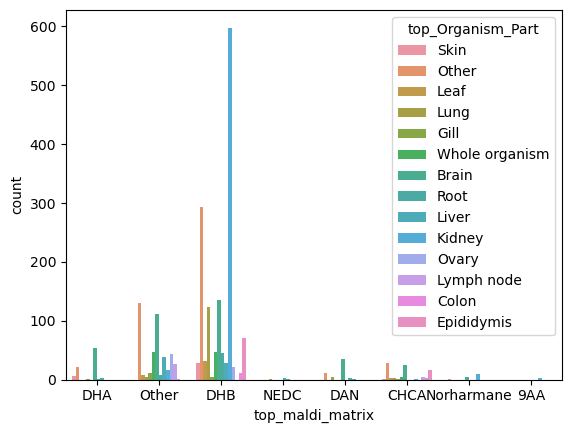

In [11]:
sns.countplot(data=adata_pos.obs, x='top_maldi_matrix', hue='top_Organism_Part')

## DHB

In [12]:
adata_pos_dhb = adata_pos[adata_pos.obs['top_maldi_matrix']=='DHB',:]

sc.pp.neighbors(adata_pos_dhb, metric='cosine')
sc.tl.leiden(adata_pos_dhb)
sc.tl.umap(adata_pos_dhb)

In [13]:
# Updated min mass

min_mass_dict = {}
max_mass_dict = {}

for i in range(adata_pos_dhb.X.shape[0]):
    ds_id = adata_pos_dhb.obs.index[i]
    dataslice = adata_pos_dhb.X[i, :] > 0
    
    min_mass_dict[ds_id] = adata_pos_dhb.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adata_pos_dhb.var['mass'][dataslice].max()
    
adata_pos_dhb.obs['minmass'] = pd.Series(min_mass_dict)
adata_pos_dhb.obs['maxmass'] = pd.Series(max_mass_dict)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


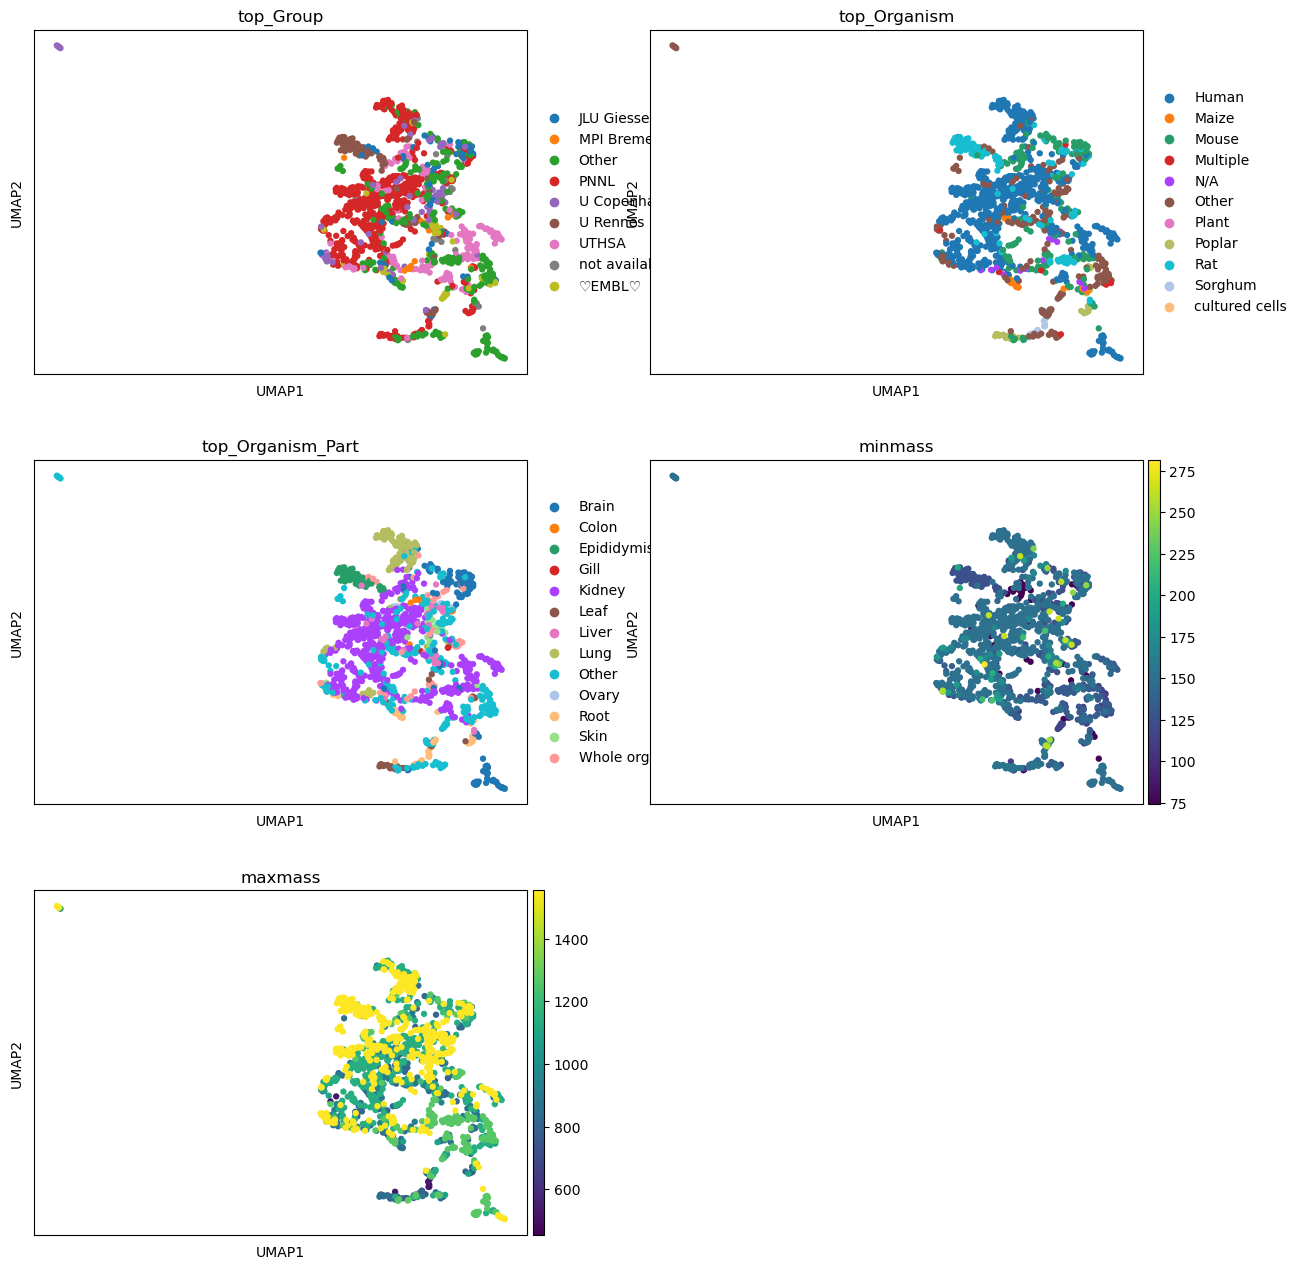

In [14]:
sc.pl.umap(adata_pos_dhb, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

In [15]:
adata_pos.var['mass'][dataslice].min()

136.151519

<AxesSubplot: xlabel='minmass', ylabel='Count'>

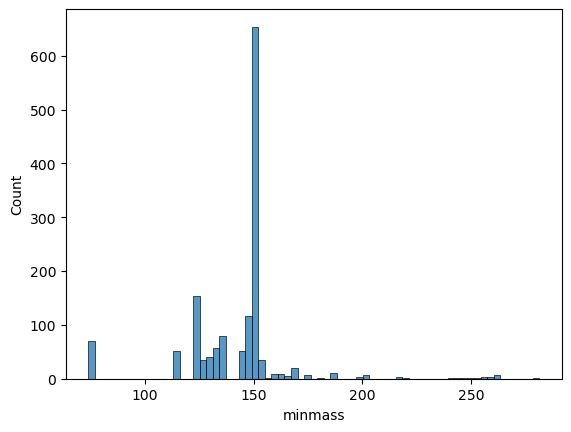

In [16]:
sns.histplot(data=adata_pos_dhb.obs, x='minmass')

<AxesSubplot: xlabel='maxmass', ylabel='Count'>

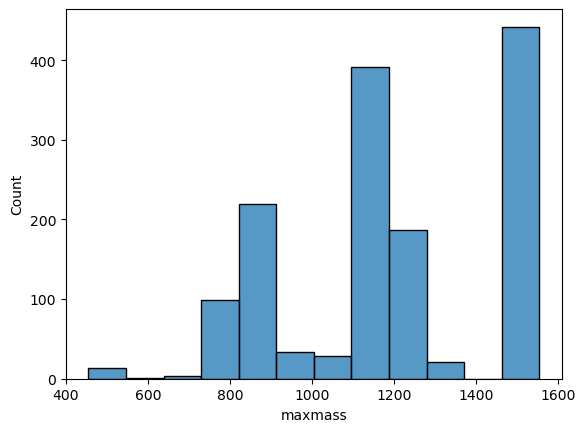

In [17]:
sns.histplot(data=adata_pos_dhb.obs, x='maxmass')

## MZ range

In [18]:
(adata_pos_dhb.var['mass'] > 100) & (adata_pos_dhb.var['mass'] > 100)

molecule
C18H34O4     True
C36H71NO3    True
C29H48O3     True
C19H38O4     True
C21H14O9     True
             ... 
C6H5ClO5     True
C57H96O5     True
C28H34O15    True
C25H22O14    True
C20H32O2     True
Name: mass, Length: 714, dtype: bool

In [19]:
adata_pos_dhb_mz = adata_pos_dhb[:,adata_pos_dhb.var['mass'] < 1400]
adata_pos_dhb_mz = adata_pos_dhb_mz[:,adata_pos_dhb_mz.var['mass'] > 100]

sc.pp.pca(adata_pos_dhb_mz)
sc.pp.neighbors(adata_pos_dhb_mz, metric='cosine')
sc.tl.leiden(adata_pos_dhb_mz)
sc.tl.umap(adata_pos_dhb_mz)

In [20]:
adata_pos_dhb_mz

AnnData object with n_obs × n_vars = 1439 × 711
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


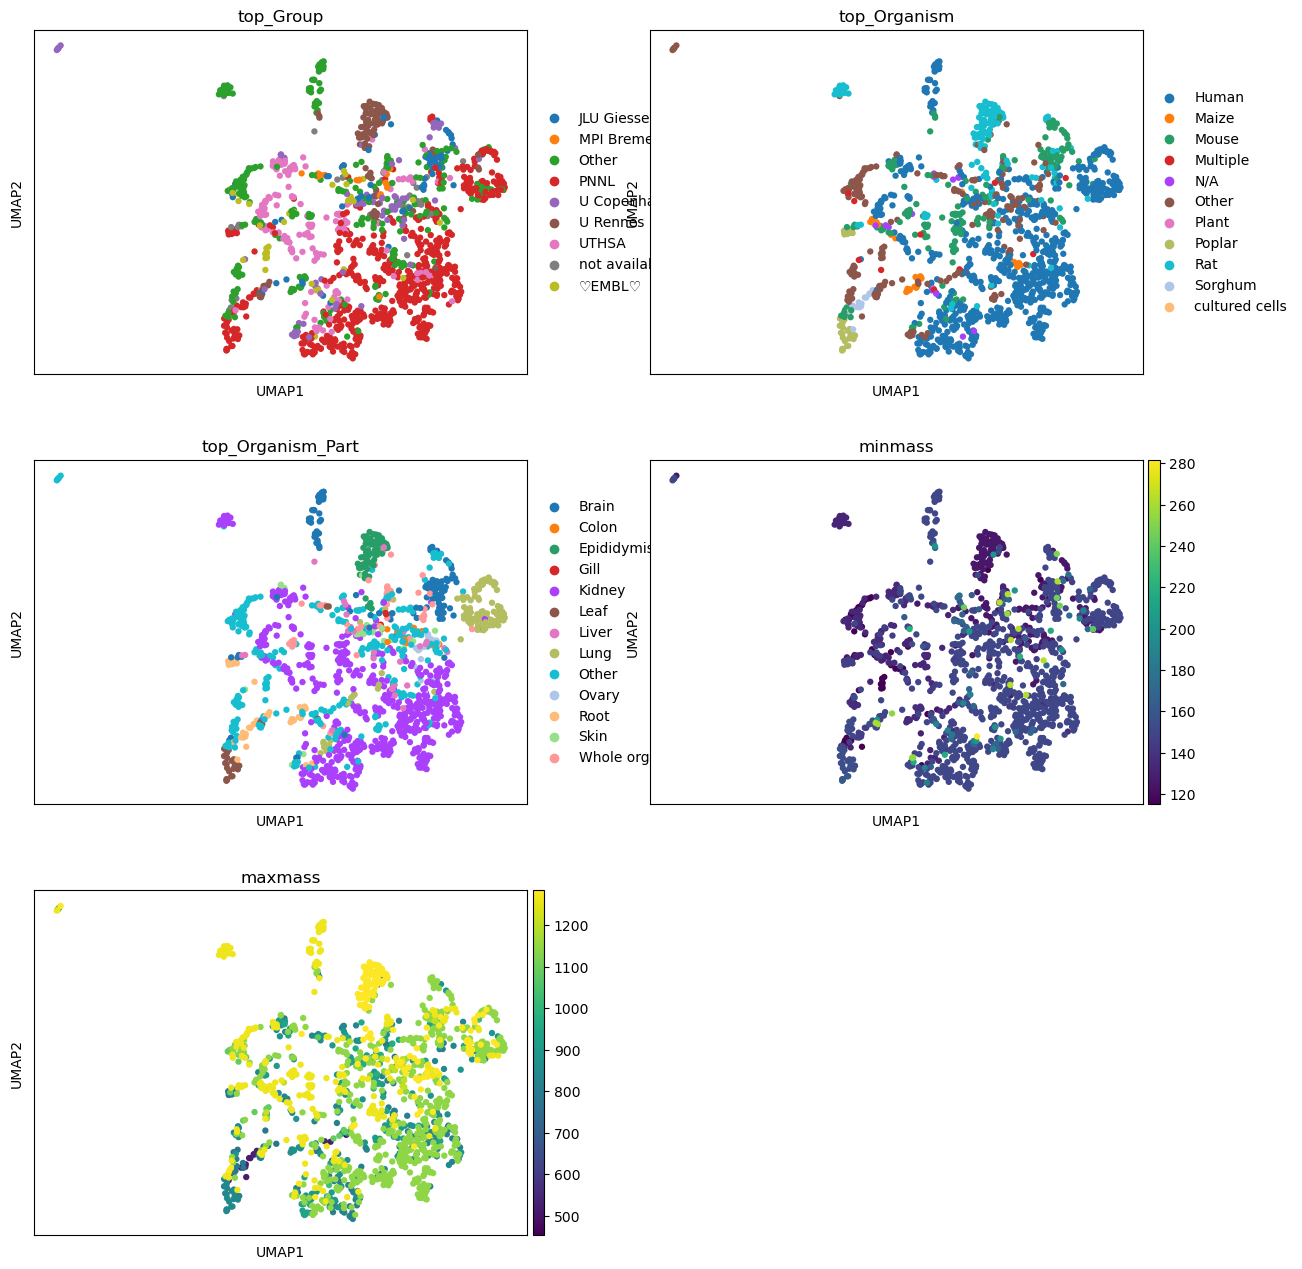

In [21]:
adat = adata_pos_dhb_mz
min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## Select tissues

In [22]:
# Tissues
tissue_list = ['Brain', 'Colon', 'Epididymis', 'Kidney', 'Liver', 'Lung', 'Ovary', 'Skin']


adata_pos_dhb_mz_tissue = adata_pos_dhb_mz[adata_pos_dhb_mz.obs['top_Organism_Part'].isin(tissue_list), :]
sc.pp.filter_genes(adata_pos_dhb_mz_tissue, min_cells=5)

sc.pp.pca(adata_pos_dhb_mz_tissue)
sc.pp.neighbors(adata_pos_dhb_mz_tissue, metric='cosine')
sc.tl.leiden(adata_pos_dhb_mz_tissue)
sc.tl.umap(adata_pos_dhb_mz_tissue)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [23]:
adata_pos_dhb_mz_tissue

AnnData object with n_obs × n_vars = 1017 × 691
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [24]:
np.isnan(adata_pos_dhb_mz.X).any()

False

In [25]:
pd.get_dummies(adata_pos_dhb_mz_tissue.obs['top_Organism_Part']).to_numpy()

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


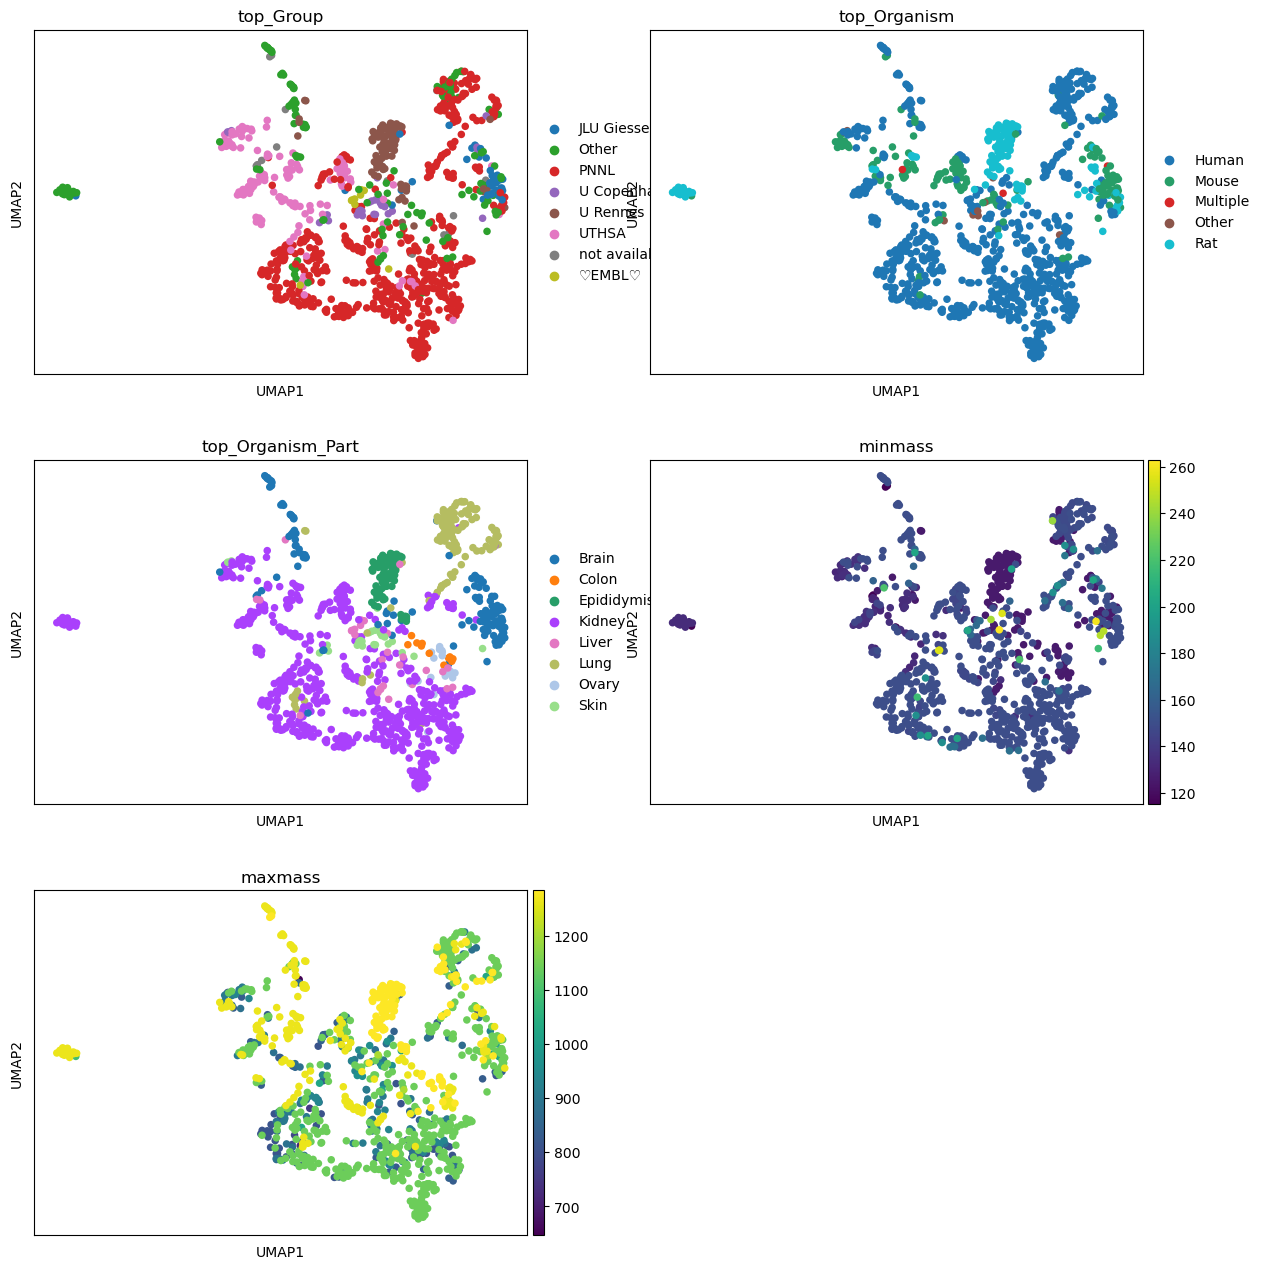

In [26]:
adat = adata_pos_dhb_mz_tissue
min_mass_dict = {}
max_mass_dict = {}

for i in range(adat.X.shape[0]):
    ds_id = adat.obs.index[i]
    dataslice = adat.X[i, :] > 0
    
    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
adat.obs['minmass'] = pd.Series(min_mass_dict)
adat.obs['maxmass'] = pd.Series(max_mass_dict)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## Ignored: Correcting lab effect

Does not make sense with combat, maybe try other tools later

In [27]:
# adata_pos_dhb_mz_tissue_cor = adata_pos_dhb_mz_tissue.copy()

In [28]:
#tmp = sc.pp.combat(adata_pos_dhb_mz_tissue_cor, 
#             key='top_Group', 
#             inplace=False,
#             covariates=['top_Organism_Part']
#            )

#adata_pos_dhb_mz_tissue_cor.X = tmp

In [29]:
#sc.pp.pca(adata_pos_dhb_mz_tissue_cor)
#sc.pp.neighbors(adata_pos_dhb_mz_tissue_cor, metric='cosine')
#sc.tl.leiden(adata_pos_dhb_mz_tissue_cor)
#sc.tl.umap(adata_pos_dhb_mz_tissue_cor)


In [30]:
#adat = adata_pos_dhb_mz_tissue_cor
#min_mass_dict = {}
#max_mass_dict = {}

#for i in range(adat.X.shape[0]):
#    ds_id = adat.obs.index[i]
#    dataslice = adat.X[i, :] > 0
    
#    min_mass_dict[ds_id] = adat.var['mass'][dataslice].min()
#    max_mass_dict[ds_id] = adat.var['mass'][dataslice].max()
    
#adat.obs['minmass'] = pd.Series(min_mass_dict)
#adat.obs['maxmass'] = pd.Series(max_mass_dict)

#sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
#           ncols=2)

## Tissue prototyping

In [31]:
tissue_mol_freq = {}
tissue_top_datasets = {}

mol_freq_cutoff = 0.1 # Initial: 0.1
top_ds_cutoff = 0.2 # Initial: 0.2


### Brain

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


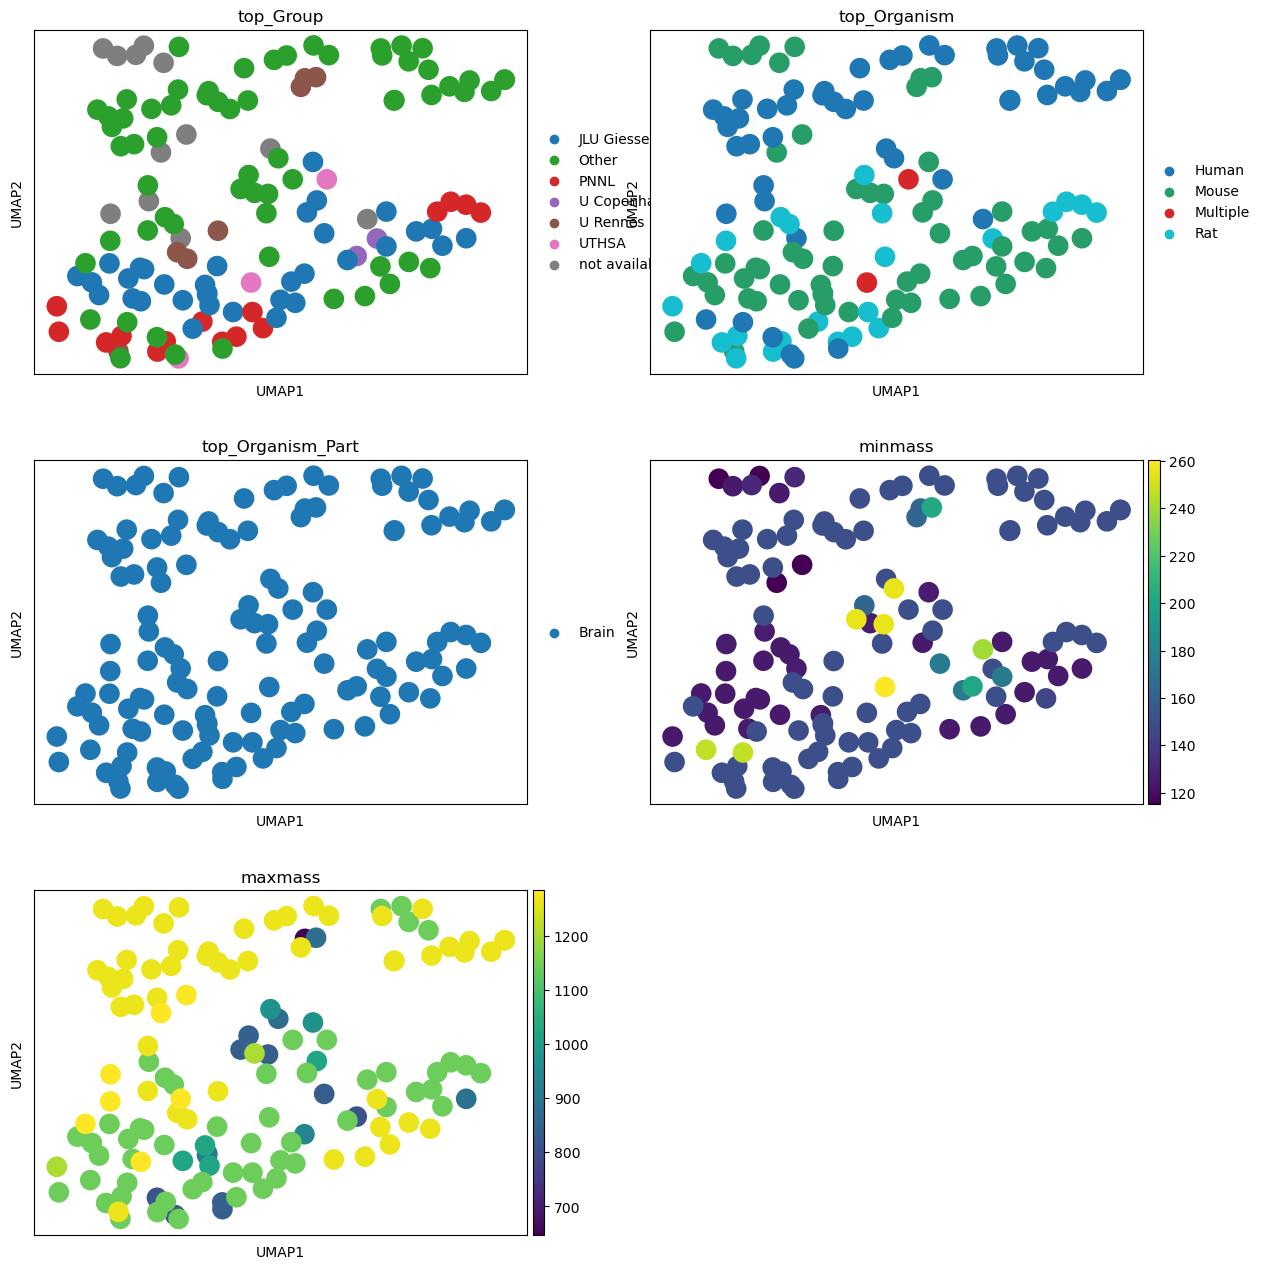

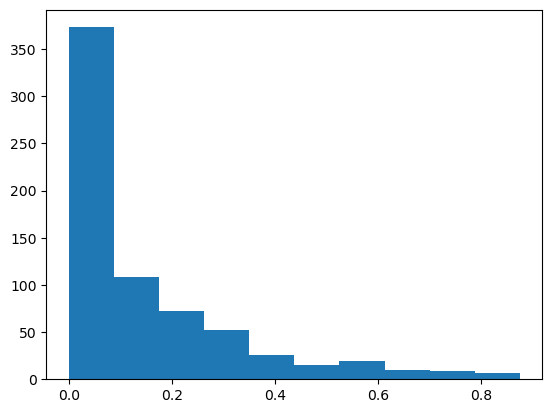

2022-08-23_23h48m59s    64
2022-07-19_19h29m24s    69
2021-12-01_13h25m50s    73
2021-11-11_11h49m37s    75
2021-11-04_14h12m55s    71
2021-11-04_11h38m42s    66
2021-11-04_10h59m58s    63
2019-03-28_09h18m57s    65
2018-08-01_14h26m17s    67
2018-08-01_14h25m56s    67
2018-08-01_14h25m21s    67
2018-08-01_14h24m55s    65
2018-08-01_14h24m33s    65
2018-08-01_14h24m14s    65
2018-08-01_14h23m58s    63
2018-08-01_14h23m33s    63
2018-08-01_14h23m16s    63
2018-08-01_14h21m22s    67
2018-08-01_14h21m02s    65
2018-08-01_14h20m46s    65
2018-08-01_14h20m30s    65
2018-08-01_14h20m09s    63
2018-08-01_14h19m50s    63
2018-08-01_14h19m26s    63
2017-02-24_13h22m14s    73
2016-09-21_16h06m56s    69
2017-02-17_14h41m43s    75
2017-02-17_14h56m37s    74
2016-09-21_16h06m55s    68
dtype: int64


In [33]:
tissue = 'Brain'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(top_datasets)

In [61]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C41H72NO7P  -  ['PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))', 'PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)', 'PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C42H84NO8P  -  ['PC(14:0/20:0)', 'PC(16:0/18:0)', 'PC(18:0/16:0)', 'PC(20:0/14:0)']
C40H79O10P  -  ['PG(16:0/18:0)', 'PG(18:0/16:0)', 'PG(a-13:0/a-21:0)', 'PG(a-13:0/i-21:0)']
C25H47NO5  -  ['3-Hydroxy-11Z-octadecenoylcarnitine', '3-Hydroxy-9Z-octadecenoylcarnitine']
C32H45NO4  -  ['Gymnodimine']
C28H33O14  -  ['Pelargonidin 3-sophoroside']
C42H80NO10P  -  ['PS(18:0/18:1(9Z))', 'PS(18:1(9Z)/18:0)', 'PS(14:1(9Z)/22:0)', 'PS(16:0/20:1(11Z))']
C37H68O4  -  ['Cohibin C', 'Cohibin D']
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 'PC(16:1(9Z)/20:0)']
C43H84NO8P  -  ['PC(15:0/20:1(11Z))', 'PC(20:1(11Z)/15:0)', 'PE(14:0/24:1(15Z))', 'PE(14:1(9Z)/24:0)']
C26H54NO7P  -  ['LysoPC(18:0/0:0)', 'LysoPC(0:0/18:0)', 'Platelet-activating factor']
C48H91NO8  -  ['GlcCer(d18:1/24:1(15Z))', 'Galactosylce

In [62]:
adat

AnnData object with n_obs × n_vars = 136 × 703
    obs: 'Organism', 'Condition', 'Organism_Part', 'Polarity', 'maldi_matrix', 'Group', 'mzmin', 'mzmax', 'Analyzer', 'Ionisation_Source', 'top_Organism', 'top_Condition', 'top_Organism_Part', 'top_Polarity', 'top_maldi_matrix', 'top_Group', 'n_genes', 'leiden', 'minmass', 'maxmass'
    var: 'n_cells', 'mass'
    uns: 'neighbors', 'umap', 'leiden', 'top_Group_colors', 'top_Organism_colors', 'top_Organism_Part_colors', 'pca'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

### Colon


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


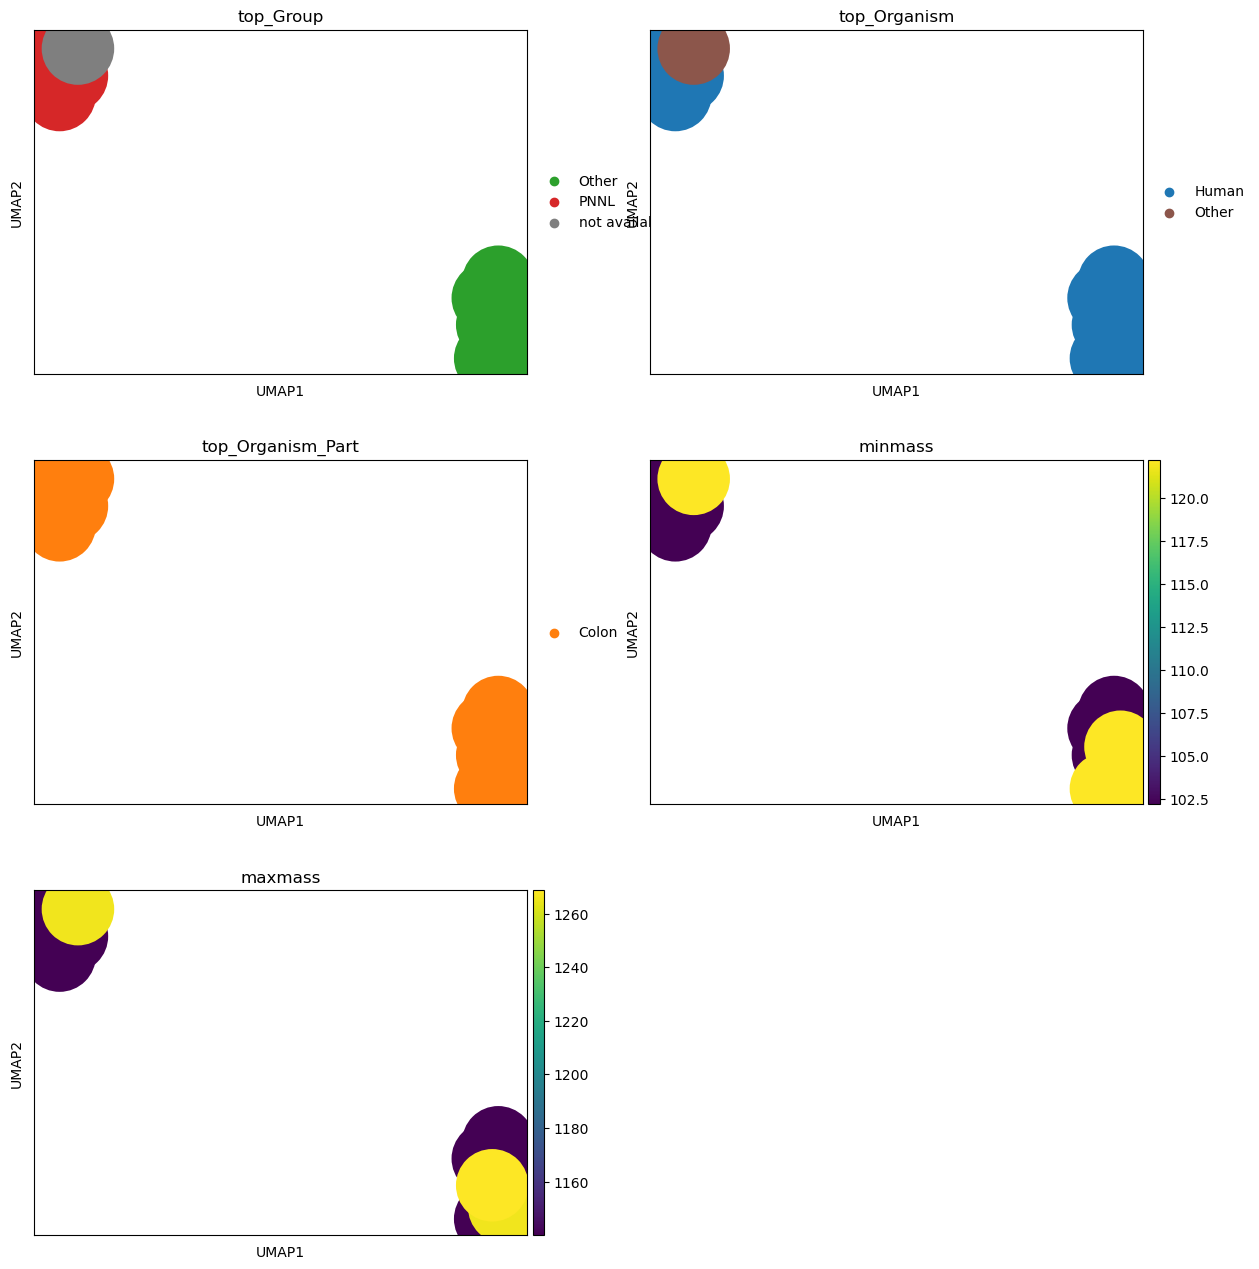

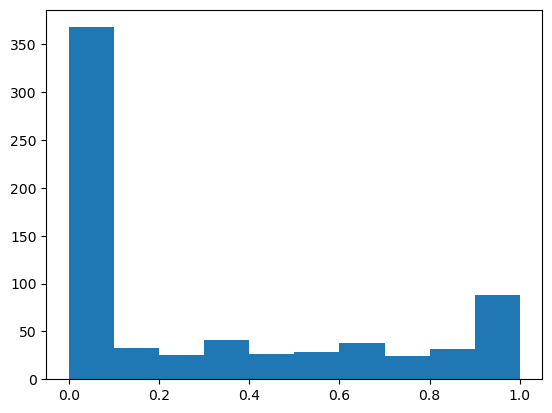

In [63]:
tissue = 'Colon'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)


mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [64]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C55H98O6  -  ['TG(16:0/16:0/20:4(5Z,8Z,11Z,14Z))', 'TG(16:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:1(9Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/18:3(9Z,12Z,15Z))']
C39H76NO10P  -  ['PS(15:0/18:0)', 'PS(18:0/15:0)']
C41H72NO7P  -  ['PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))', 'PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)', 'PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C57H100O6  -  ['TG(16:0/18:1(9Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(16:1(9Z)/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:1(9Z)/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/20:4(5Z,8Z,11Z,14Z))']
C42H84NO8P  -  ['PC(14:0/20:0)', 'PC(16:0/18:0)', 'PC(18:0/16:0)', 'PC(20:0/14:0)']
C22H22O7  -  ['Dulxanthone E', "5'-Methoxycurcumin"]
C53H96O6  -  ['TG(16:0/16:1(9Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/16:1(9Z)/18:1(9Z))', 'TG(16:0/16:0/18:3(9Z,12Z,15Z))', 'TG(18:1(11Z)/14:0/18:2(9Z,12Z))']
C55H102O6  -  ['TG(16:0/18:0/18:2(9Z,12Z))', 'TG(16:0/16:1(9Z)/20:1(11Z))', 'TG(16:0/18:1(9Z)/18:1(9Z))', 'TG(16:1(9Z)/18:0/18:1(9Z))']
C37H70O5 

### Epididymis

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


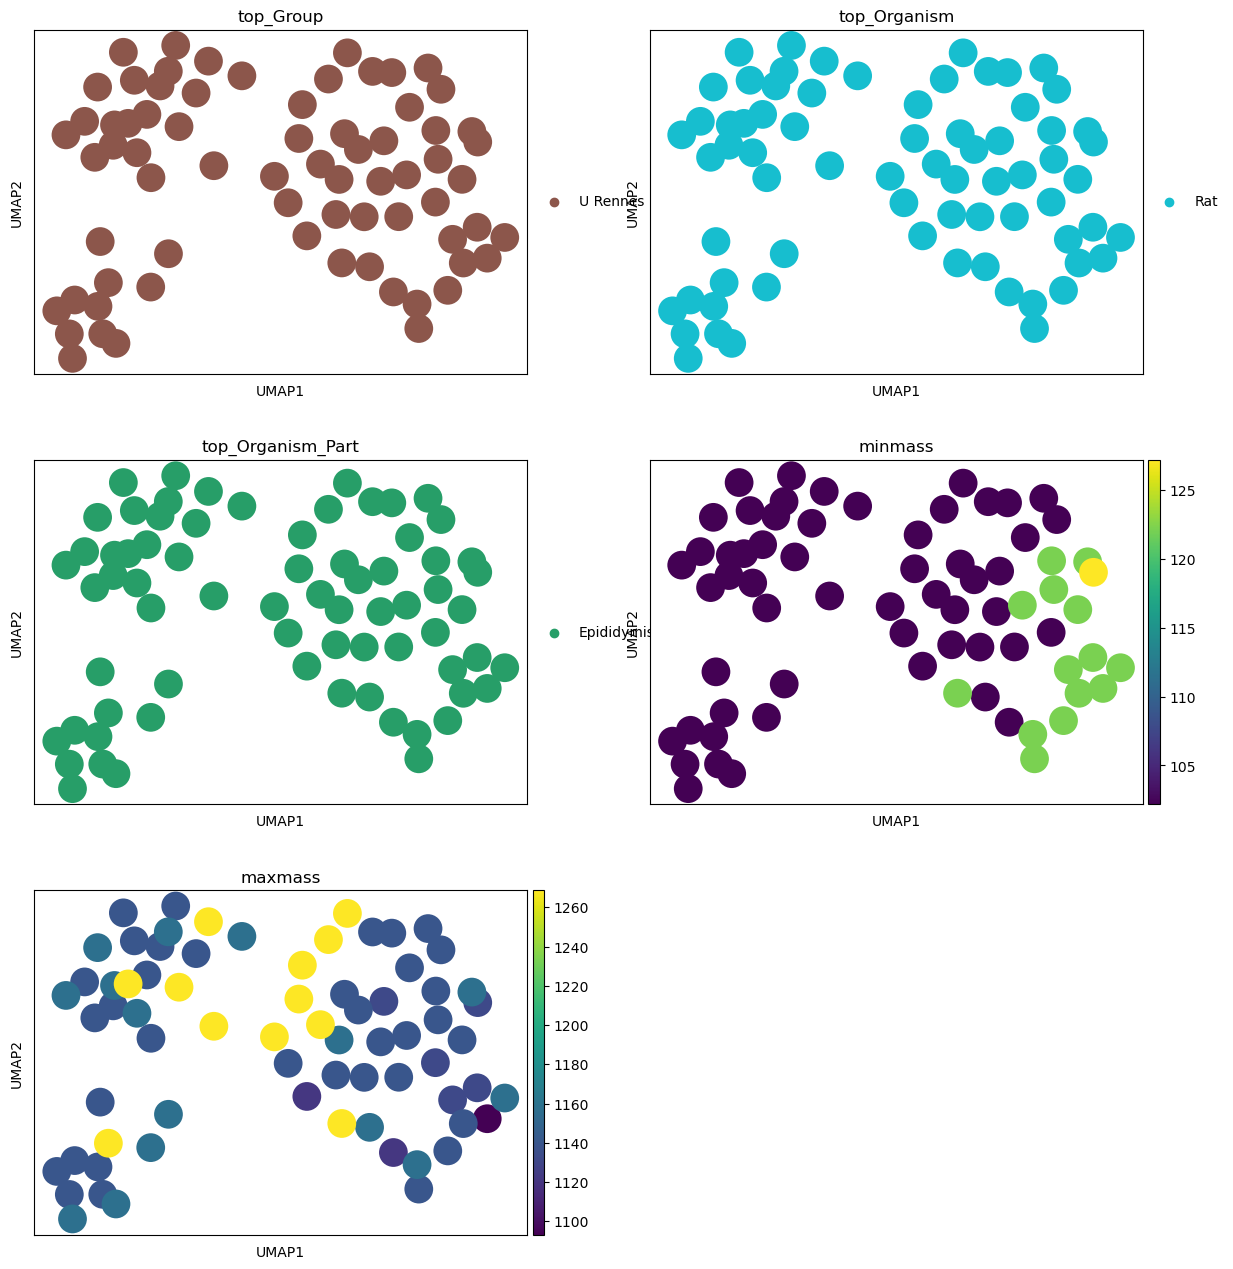

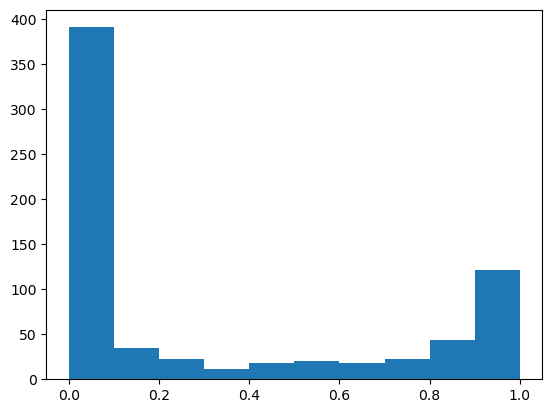

In [65]:
tissue = 'Epididymis'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [66]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C42H84NO8P  -  ['PC(14:0/20:0)', 'PC(16:0/18:0)', 'PC(18:0/16:0)', 'PC(20:0/14:0)']
C53H96O6  -  ['TG(16:0/16:1(9Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/16:1(9Z)/18:1(9Z))', 'TG(16:0/16:0/18:3(9Z,12Z,15Z))', 'TG(18:1(11Z)/14:0/18:2(9Z,12Z))']
C41H77O8P  -  ['PA(14:1(9Z)/24:1(15Z))', 'PA(16:0/22:2(13Z,16Z))', 'PA(16:1(9Z)/22:1(13Z))', 'PA(18:1(11Z)/20:1(11Z))']
C48H88NO8P  -  ['PC(18:0/22:4(7Z,10Z,13Z,16Z))', 'PC(18:2(9Z,12Z)/22:2(13Z,16Z))', 'PC(18:3(6Z,9Z,12Z)/22:1(13Z))', 'PC(18:3(9Z,12Z,15Z)/22:1(13Z))']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C25H47NO5  -  ['3-Hydroxy-11Z-octadecenoylcarnitine', '3-Hydroxy-9Z-octadecenoylcarnitine']
C32H45NO4  -  ['Gymnodimine']
C43H74O4  -  ['5-Hydroxy-7-methoxy-2-tritriacontyl-4H-1-benzopyran-4-one']
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 'PC(16:1(9Z)/20:0)']
C28H52NO7P  -  ['LysoPC(20:3(5Z,8Z,11Z)/0:0)', 'LysoPC(20:3(8Z,11

### Kidney

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


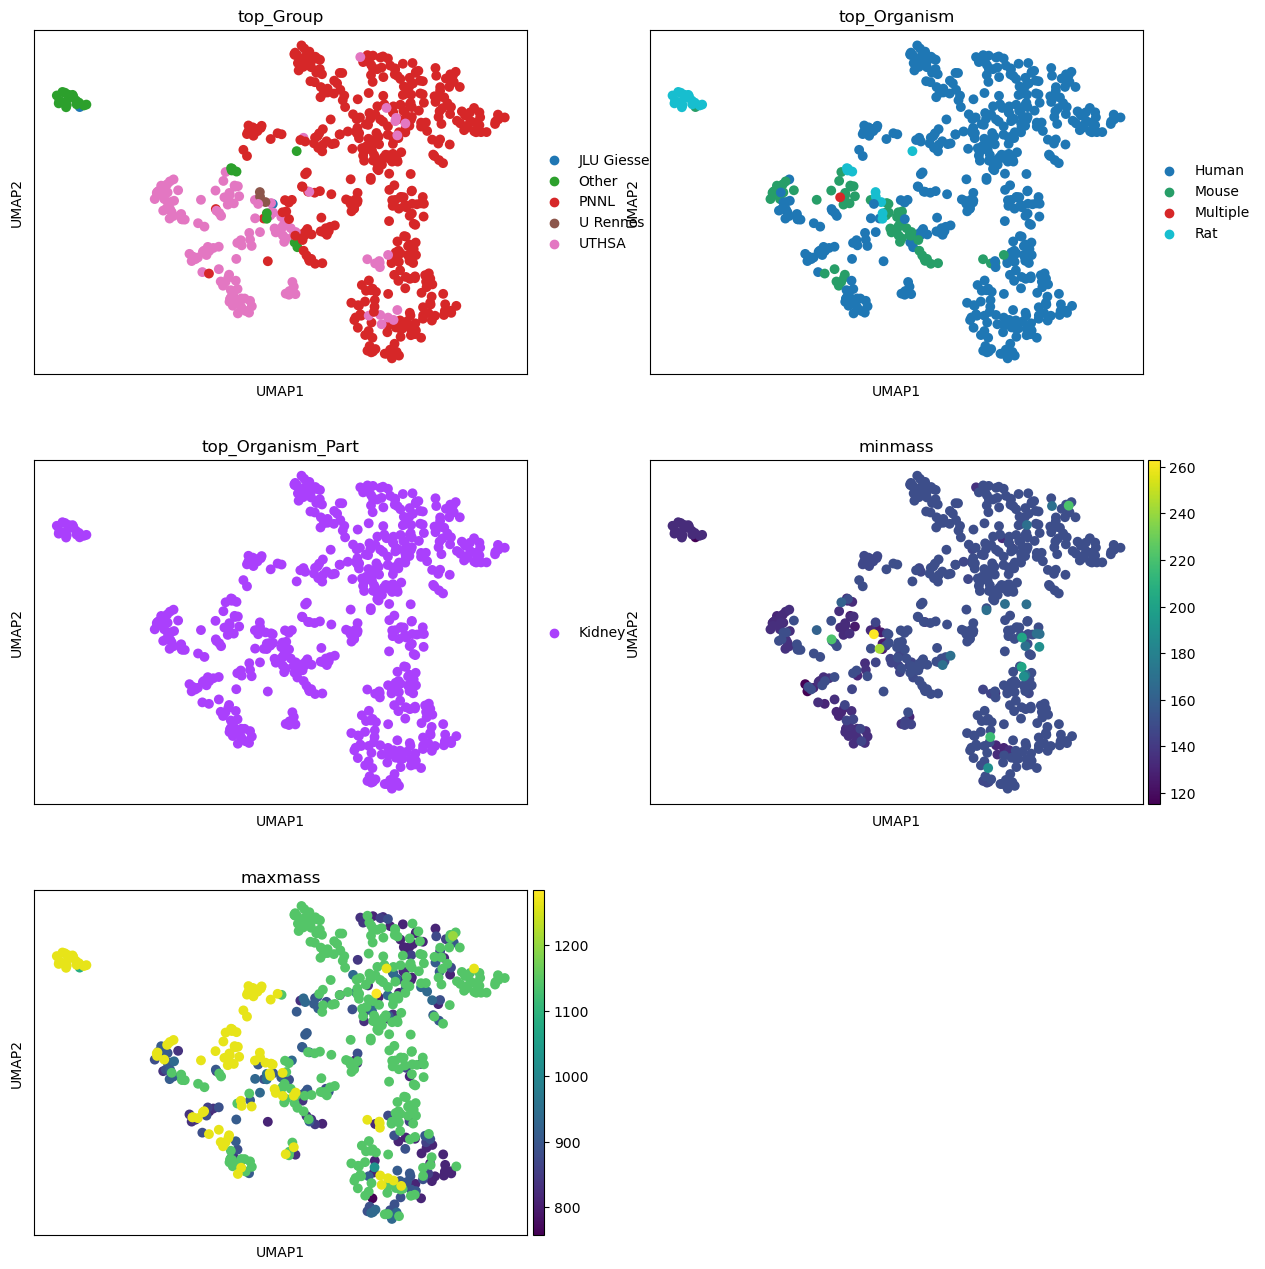

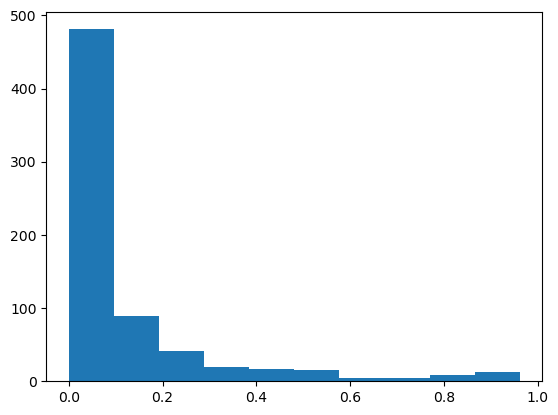

2020-01-21_22h56m53s    70
2020-01-09_19h06m59s    70
2020-01-06_22h03m31s    70
2020-01-06_22h02m51s    69
2020-01-09_21h14m40s    69
                        ..
2019-01-22_21h37m11s    58
2022-12-07_01h59m02s    58
2022-12-07_01h56m07s    58
2018-09-12_09h25m43s    58
2018-09-14_22h39m12s    58
Length: 128, dtype: int64


In [35]:
tissue = 'Kidney'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(top_datasets.sort_values(ascending=False))

In [68]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C55H98O6  -  ['TG(16:0/16:0/20:4(5Z,8Z,11Z,14Z))', 'TG(16:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:1(9Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/18:3(9Z,12Z,15Z))']
C57H100O6  -  ['TG(16:0/18:1(9Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(16:1(9Z)/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:1(9Z)/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/20:4(5Z,8Z,11Z,14Z))']
C42H84NO8P  -  ['PC(14:0/20:0)', 'PC(16:0/18:0)', 'PC(18:0/16:0)', 'PC(20:0/14:0)']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C55H102O6  -  ['TG(16:0/18:0/18:2(9Z,12Z))', 'TG(16:0/16:1(9Z)/20:1(11Z))', 'TG(16:0/18:1(9Z)/18:1(9Z))', 'TG(16:1(9Z)/18:0/18:1(9Z))']
C28H33O14  -  ['Pelargonidin 3-sophoroside']
C46H93N2O6P  -  ['SM(d17:1/24:0)', 'SM(d18:1/23:0)']
C45H89N2O6P  -  ['SM(d16:1/24:1(15Z))', 'SM(d18:1/22:1(13Z))', 'SM(d18:2(4E,14Z)/22:0)']
C37H68O4  -  ['Cohibin C', 'Cohibin D']
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11

### Liver

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


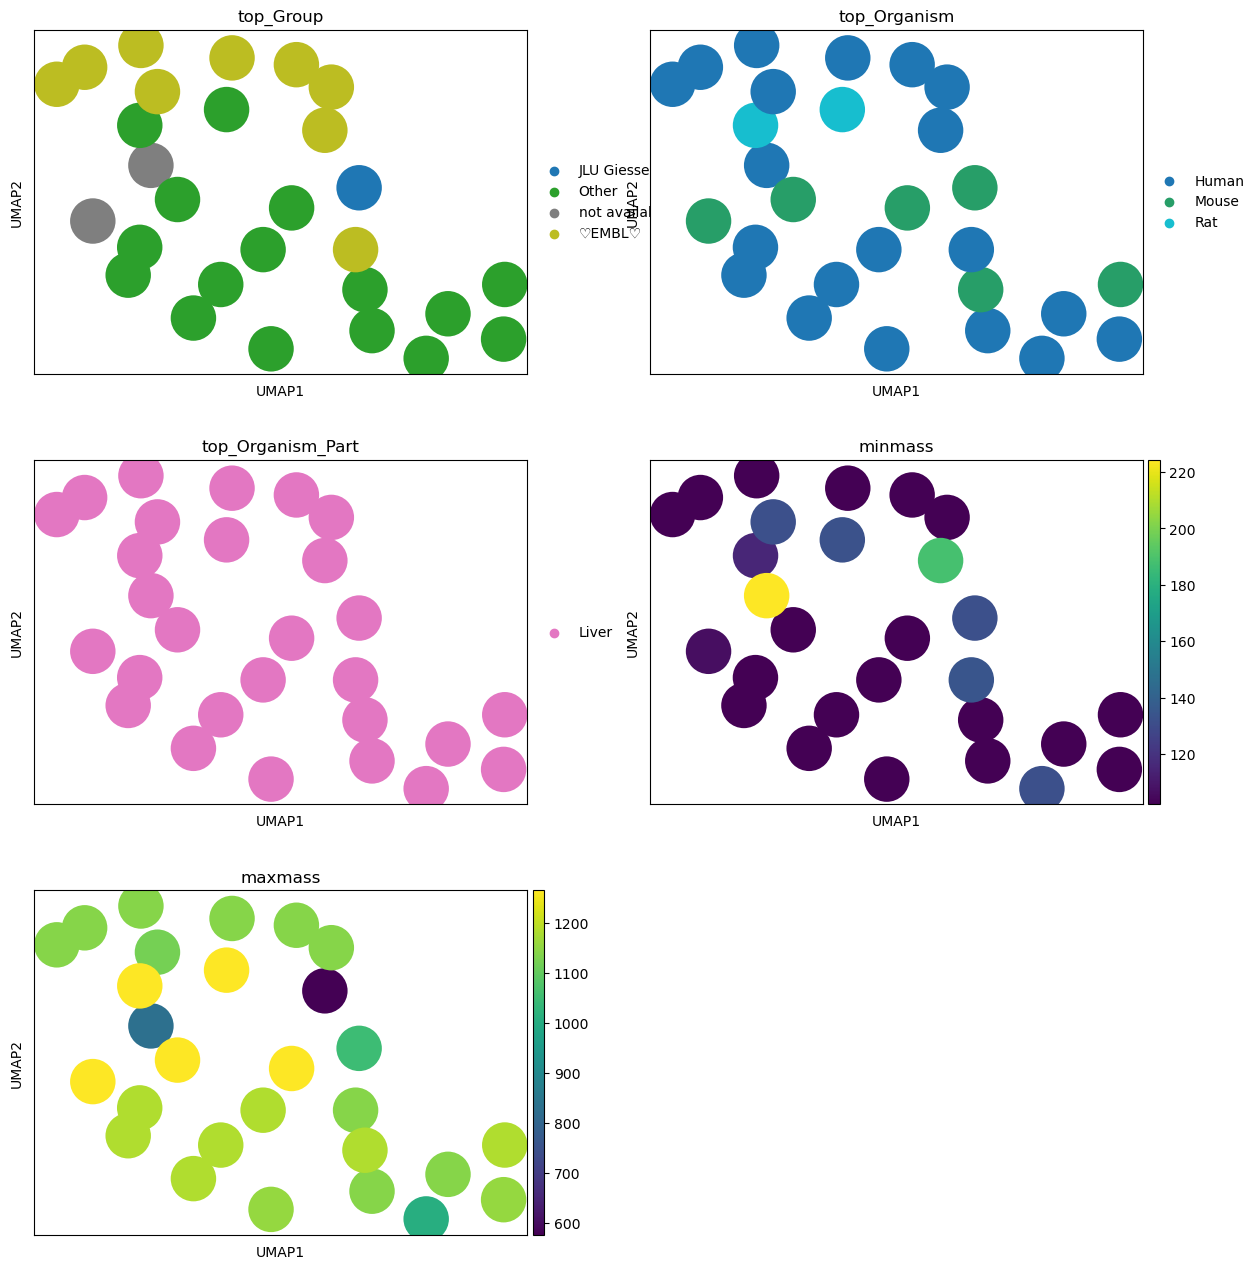

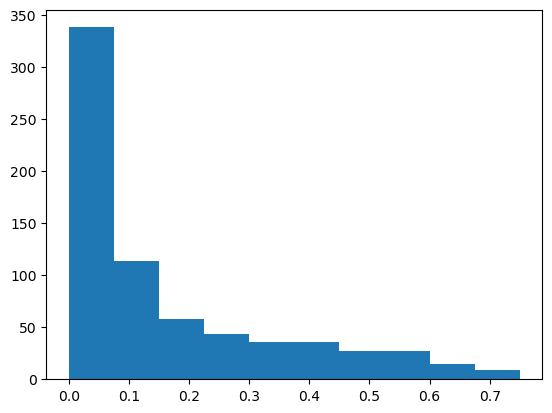

In [69]:
tissue = 'Liver'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [70]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C55H98O6  -  ['TG(16:0/16:0/20:4(5Z,8Z,11Z,14Z))', 'TG(16:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:1(9Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/18:3(9Z,12Z,15Z))']
C57H100O6  -  ['TG(16:0/18:1(9Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(16:1(9Z)/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:1(9Z)/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/20:4(5Z,8Z,11Z,14Z))']
C42H82NO6P  -  ['CerP(d18:1/24:1(15Z))', 'PC(P-16:0/P-18:1(11Z))', 'PC(P-16:0/P-18:1(9Z))', 'PC(P-18:1(11Z)/P-16:0)']
C42H84NO8P  -  ['PC(14:0/20:0)', 'PC(16:0/18:0)', 'PC(18:0/16:0)', 'PC(20:0/14:0)']
C53H96O6  -  ['TG(16:0/16:1(9Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/16:1(9Z)/18:1(9Z))', 'TG(16:0/16:0/18:3(9Z,12Z,15Z))', 'TG(18:1(11Z)/14:0/18:2(9Z,12Z))']
C40H79O10P  -  ['PG(16:0/18:0)', 'PG(18:0/16:0)', 'PG(a-13:0/a-21:0)', 'PG(a-13:0/i-21:0)']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C55H102O6  -  ['TG(16:0/18:0/18:2(9Z,12Z))', 'TG(16:0/16:1(9Z)/20:1(11Z))', '

### Lung

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


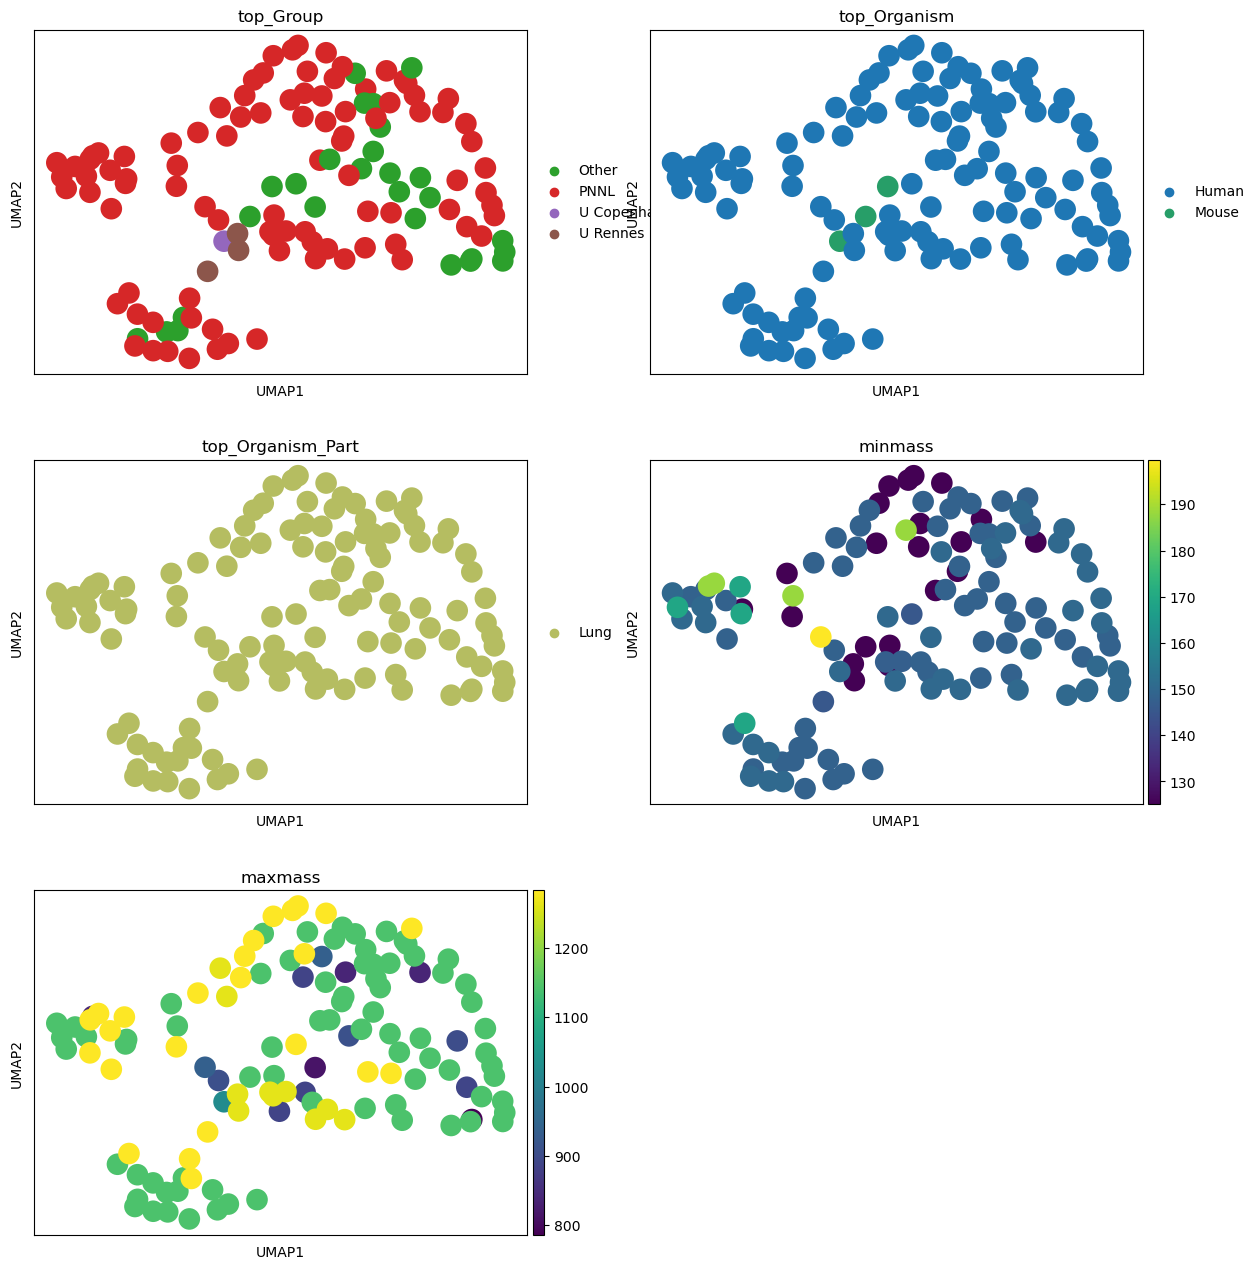

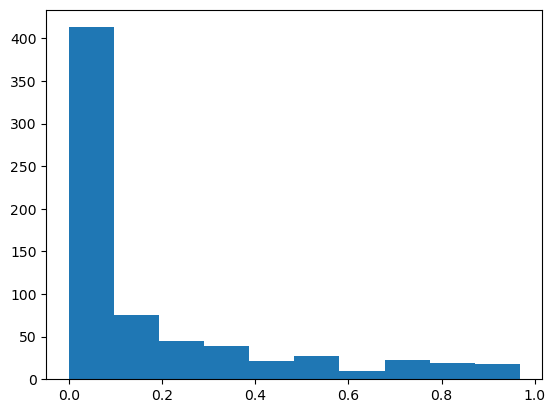

2023-01-25_03h20m26s    70
2021-08-16_23h19m40s    70
2020-02-24_20h07m11s    70
2020-11-18_20h19m26s    70
2020-11-18_20h21m56s    70
2020-11-18_20h23m01s    70
2020-12-22_22h54m28s    70
2020-12-22_23h01m23s    70
2021-05-19_20h09m03s    70
2021-08-09_18h34m16s    70
2021-08-09_18h39m16s    70
2021-08-09_18h51m36s    70
2021-08-09_18h40m08s    70
2021-08-16_23h37m34s    70
2021-08-17_00h06m31s    70
2021-08-16_23h52m40s    70
2021-10-11_18h34m31s    70
2021-10-11_19h06m59s    70
2021-08-16_23h19m04s    70
2021-10-11_19h38m30s    70
2021-10-11_21h07m40s    70
2021-08-16_23h18m11s    69
2020-11-12_20h48m57s    69
2022-10-17_20h30m37s    69
2020-02-24_20h44m17s    69
2020-11-12_00h16m07s    69
2020-11-18_21h50m45s    69
2022-09-24_00h10m42s    69
2020-11-18_20h24m12s    69
2020-11-18_21h53m36s    69
2022-10-27_22h05m48s    69
2019-12-04_00h41m47s    69
dtype: int64


In [36]:
tissue = 'Lung'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

print(top_datasets.sort_values(ascending=False))

In [72]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C41H72NO7P  -  ['PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))', 'PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)', 'PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C42H84NO8P  -  ['PC(14:0/20:0)', 'PC(16:0/18:0)', 'PC(18:0/16:0)', 'PC(20:0/14:0)']
C41H77O8P  -  ['PA(14:1(9Z)/24:1(15Z))', 'PA(16:0/22:2(13Z,16Z))', 'PA(16:1(9Z)/22:1(13Z))', 'PA(18:1(11Z)/20:1(11Z))']
C40H79O10P  -  ['PG(16:0/18:0)', 'PG(18:0/16:0)', 'PG(a-13:0/a-21:0)', 'PG(a-13:0/i-21:0)']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C55H102O6  -  ['TG(16:0/18:0/18:2(9Z,12Z))', 'TG(16:0/16:1(9Z)/20:1(11Z))', 'TG(16:0/18:1(9Z)/18:1(9Z))', 'TG(16:1(9Z)/18:0/18:1(9Z))']
C28H33O14  -  ['Pelargonidin 3-sophoroside']
C46H93N2O6P  -  ['SM(d17:1/24:0)', 'SM(d18:1/23:0)']
C45H89N2O6P  -  ['SM(d16:1/24:1(15Z))', 'SM(d18:1/22:1(13Z))', 'SM(d18:2(4E,14Z)/22:0)']
C44H86NO8P  -  ['PC(14:0/22:1(13Z))', 'PC(14:1(9Z)/22:0)', 'PC(16:0/20:1(11Z))', 

### Ovary

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


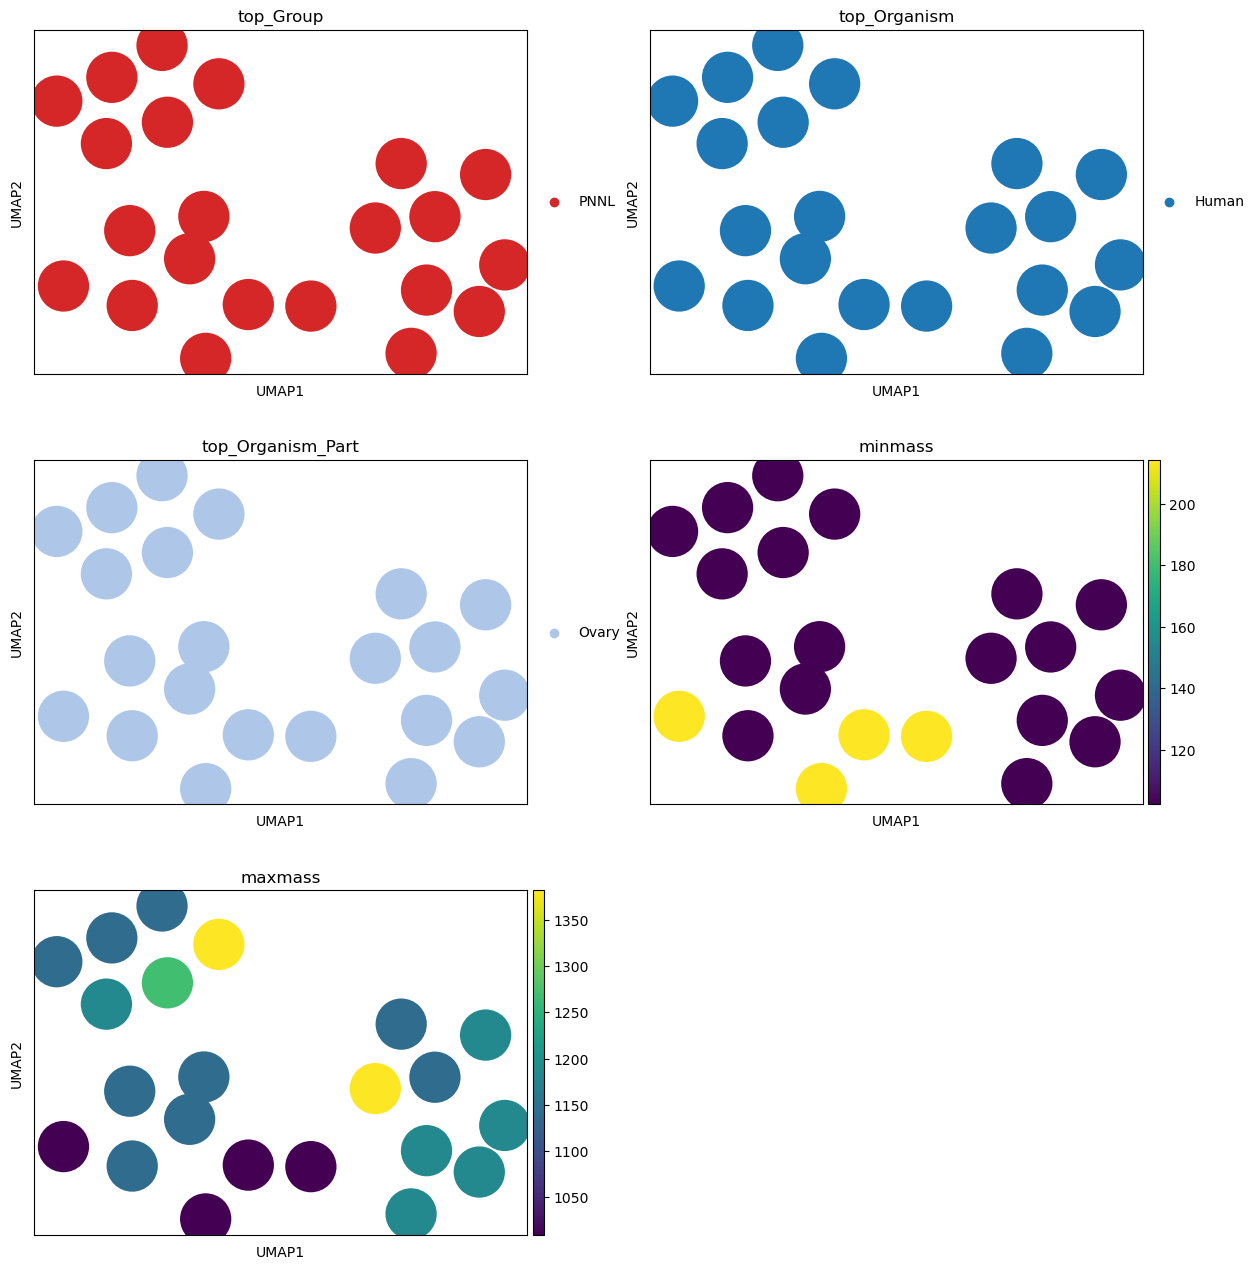

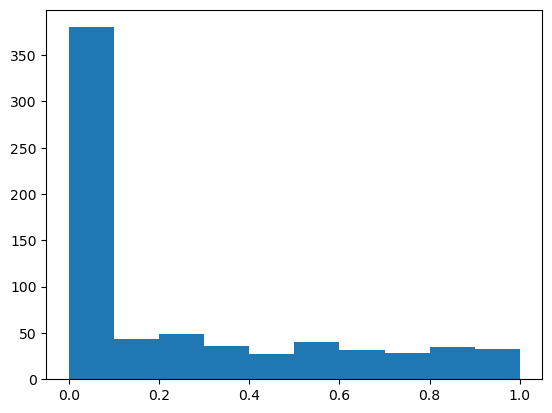

In [73]:
tissue = 'Ovary'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [74]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C55H98O6  -  ['TG(16:0/16:0/20:4(5Z,8Z,11Z,14Z))', 'TG(16:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:1(9Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/18:3(9Z,12Z,15Z))']
C41H72NO7P  -  ['PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(11Z))', 'PE(18:4(6Z,9Z,12Z,15Z)/P-18:1(9Z))', 'PE(20:5(5Z,8Z,11Z,14Z,17Z)/P-16:0)', 'PE(P-16:0/20:5(5Z,8Z,11Z,14Z,17Z))']
C57H100O6  -  ['TG(16:0/18:1(9Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(16:1(9Z)/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:1(9Z)/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/20:4(5Z,8Z,11Z,14Z))']
C42H84NO8P  -  ['PC(14:0/20:0)', 'PC(16:0/18:0)', 'PC(18:0/16:0)', 'PC(20:0/14:0)']
C22H22O7  -  ['Dulxanthone E', "5'-Methoxycurcumin"]
C48H88NO8P  -  ['PC(18:0/22:4(7Z,10Z,13Z,16Z))', 'PC(18:2(9Z,12Z)/22:2(13Z,16Z))', 'PC(18:3(6Z,9Z,12Z)/22:1(13Z))', 'PC(18:3(9Z,12Z,15Z)/22:1(13Z))']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C61H104O6  -  ['TG(18:2(9Z,12Z)/20:1(11Z)/20:4(5Z,8Z,11Z,14Z))', '

### Skin

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


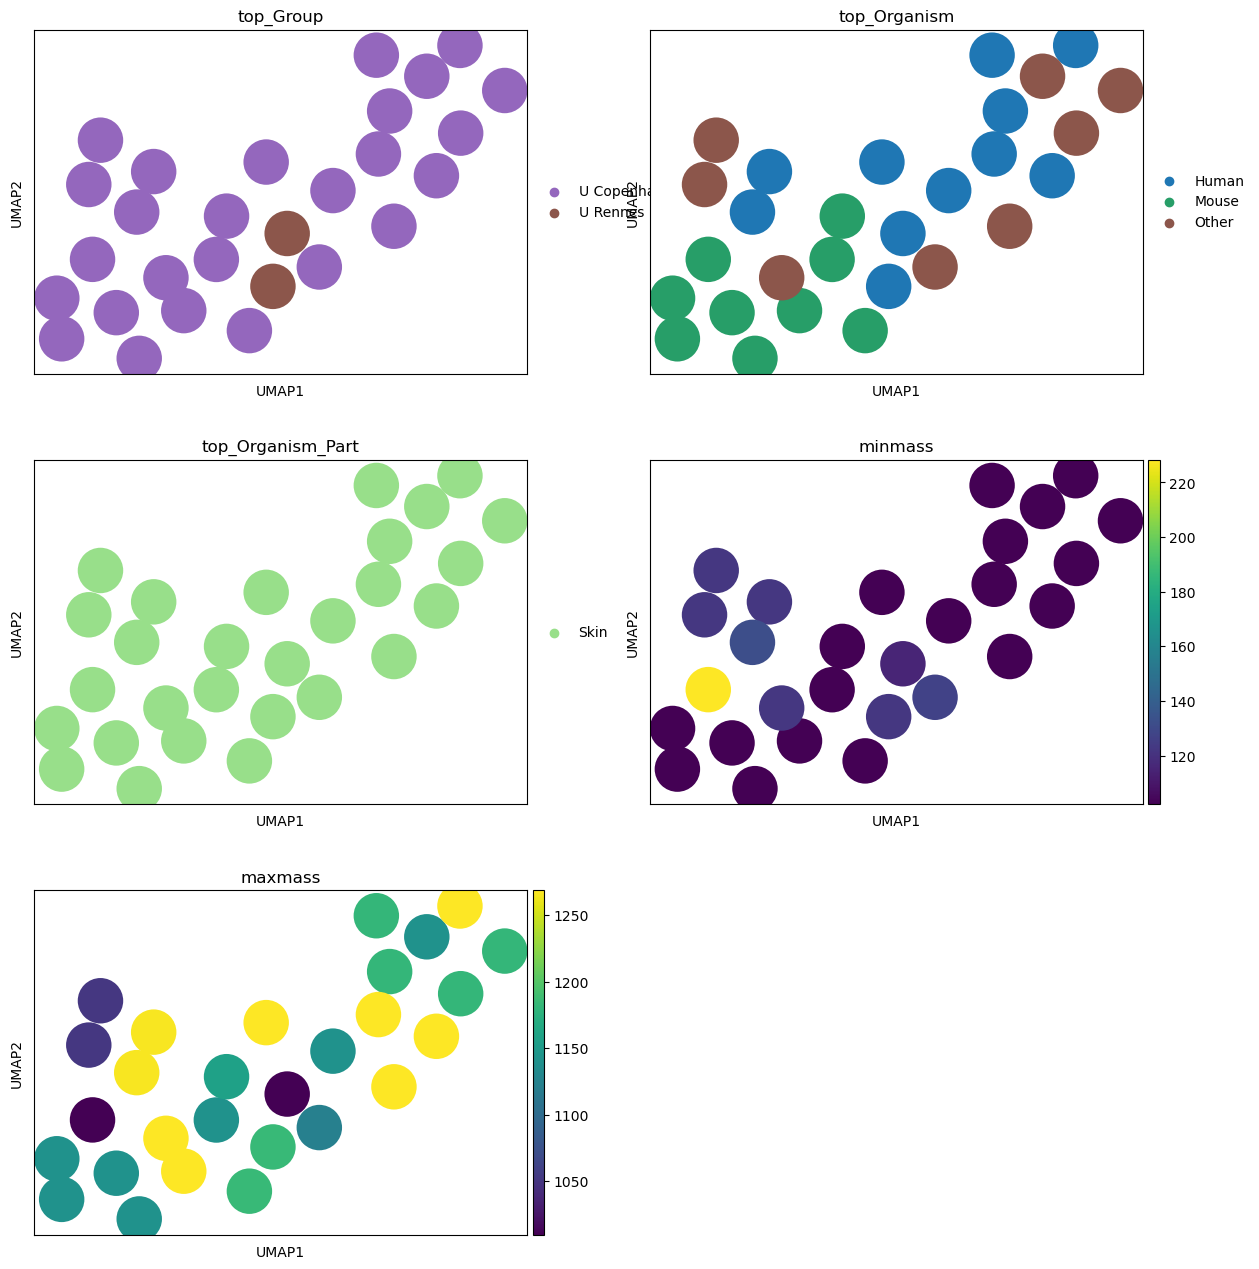

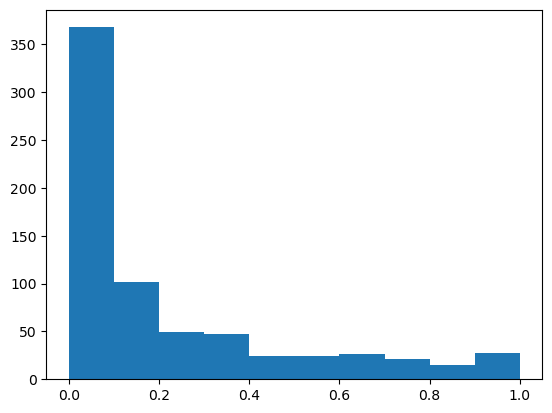

In [75]:
tissue = 'Skin'
adat = adata_pos_dhb_mz_tissue[adata_pos_dhb_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff)
tissue_mol_freq[tissue] = mol_freq2
tissue_top_datasets[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_pos_{tissue}.csv'))

In [76]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C55H98O6  -  ['TG(16:0/16:0/20:4(5Z,8Z,11Z,14Z))', 'TG(16:0/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/18:1(9Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/18:3(9Z,12Z,15Z))']
C57H100O6  -  ['TG(16:0/18:1(9Z)/20:4(5Z,8Z,11Z,14Z))', 'TG(16:1(9Z)/18:0/20:4(5Z,8Z,11Z,14Z))', 'TG(18:1(9Z)/18:2(9Z,12Z)/18:2(9Z,12Z))', 'TG(18:1(11Z)/16:0/20:4(5Z,8Z,11Z,14Z))']
C53H96O6  -  ['TG(16:0/16:1(9Z)/18:2(9Z,12Z))', 'TG(16:1(9Z)/16:1(9Z)/18:1(9Z))', 'TG(16:0/16:0/18:3(9Z,12Z,15Z))', 'TG(18:1(11Z)/14:0/18:2(9Z,12Z))']
C48H88NO8P  -  ['PC(18:0/22:4(7Z,10Z,13Z,16Z))', 'PC(18:2(9Z,12Z)/22:2(13Z,16Z))', 'PC(18:3(6Z,9Z,12Z)/22:1(13Z))', 'PC(18:3(9Z,12Z,15Z)/22:1(13Z))']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C28H33O14  -  ['Pelargonidin 3-sophoroside']
C42H80NO10P  -  ['PS(18:0/18:1(9Z))', 'PS(18:1(9Z)/18:0)', 'PS(14:1(9Z)/22:0)', 'PS(16:0/20:1(11Z))']
C37H75N2O6P  -  ['SM(d18:1/14:0)', 'SM(d16:1/16:0)']
C46H93N2O6P  -  ['SM(

## Tissue similarity

Dataset thresholding

In [125]:
freq_tab = pd.DataFrame(tissue_mol_freq).transpose()
freq_tab[freq_tab.isna()] = 0

In [126]:
sim_tab = pd.DataFrame(pairwise_kernels(freq_tab, metric='cosine'), index=freq_tab.index, columns=freq_tab.index)

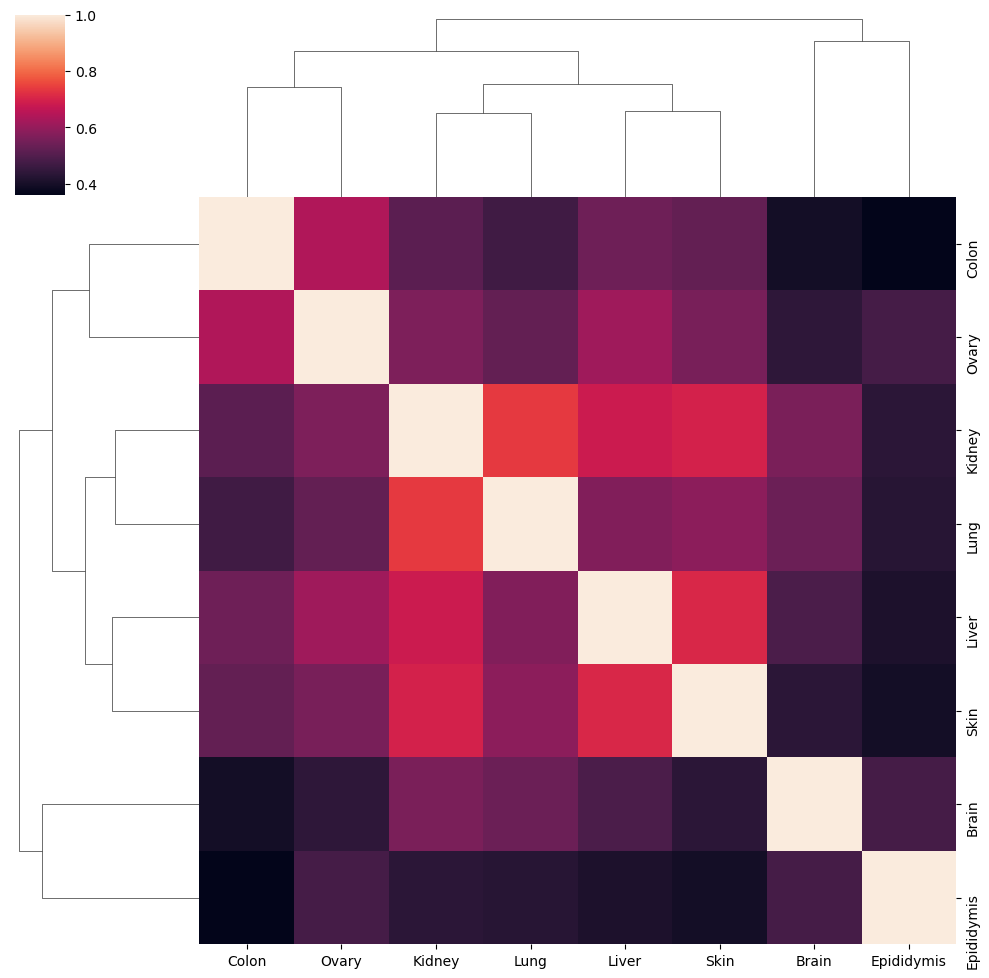

In [127]:
sns.clustermap(sim_tab)

## Network

Look into the top ions that two tissues share

In [135]:
tmp_sim_tab = sim_tab.copy()
tmp_sim_tab[tmp_sim_tab<0.6] = 0
g = nx.from_pandas_adjacency(tmp_sim_tab)
g.remove_edges_from(nx.selfloop_edges(g))

In [136]:
pos = nx.spring_layout(g, k=1.3)

/tmp/ipykernel_82/3020464191.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


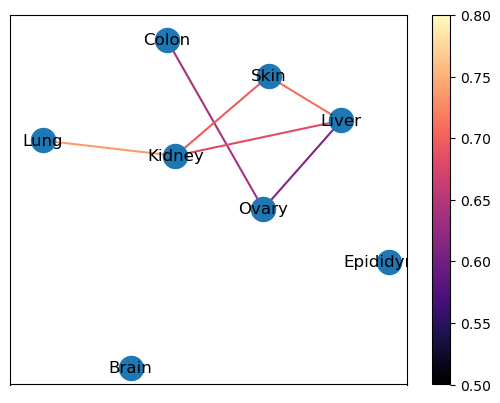

In [137]:
cm = plt.get_cmap('magma')
edge_weights = [d['weight'] for u, v, d in g.edges(data=True)]
vmin=0.5
vmax=0.8
nx.draw_networkx_edges(g, pos=pos, edge_color=edge_weights, edge_cmap=cm, width=1.5, edge_vmin=vmin, edge_vmax=vmax)
nx.draw_networkx_nodes(g, pos=pos)
nx.draw_networkx_labels(g, pos=pos)
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm)

plt.show()

In [57]:
tmp = sim_tab.melt()['value']
tmp = tmp[tmp<1]

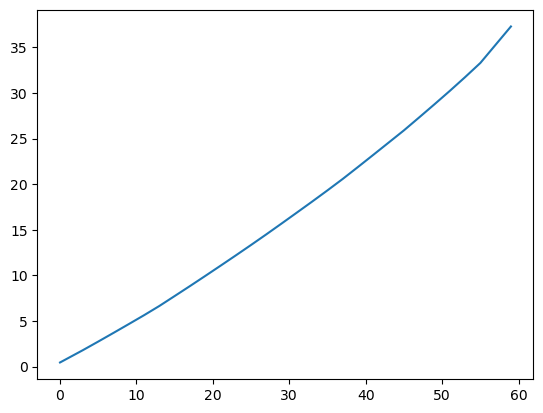

In [58]:
plt.plot(np.cumsum(tmp.sort_values().values), '-')

# Negative

In [37]:
adata_neg = adata[adata.obs['Polarity']=='Negative',:]

sc.pp.filter_genes(adata_neg, min_cells=100) # 200
sc.pp.filter_cells(adata_neg, min_genes=20) # 50
#sc.pp.normalize_total(adata_pos, target_sum=1e4)

#sc.pp.neighbors(adata_pos, metric='cosine')
#sc.tl.leiden(adata_pos)
#sc.tl.umap(adata_pos)

adata_neg.var['mass'] = [Formula(x).mass for x in adata_neg.var.index.values]

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


In [38]:
pd.DataFrame(adata_neg.var.index).to_csv(os.path.join(enrichment_dir, f'bg_neg.csv'))

<AxesSubplot: xlabel='top_maldi_matrix', ylabel='count'>

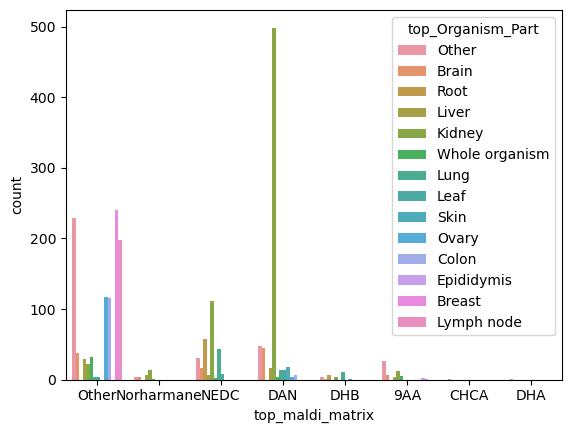

In [39]:
sns.countplot(data=adata_neg.obs, x='top_maldi_matrix', hue='top_Organism_Part')

## Matrix

Not sure which matrix should be used. Either `NEDC` or `DAN`. The workflow should probably be tested with both of them.

In [40]:
adata_neg_matrix = adata_neg[adata_neg.obs['top_maldi_matrix']=='DAN',:]

sc.tl.pca(adata_neg_matrix)
sc.pp.neighbors(adata_neg_matrix, metric='cosine')
sc.tl.leiden(adata_neg_matrix)
sc.tl.umap(adata_neg_matrix)

utils.update_minmax_mass(adata_neg_matrix)

In [41]:
adata_neg_matrix.obs['minmass'].min()

74.081937

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


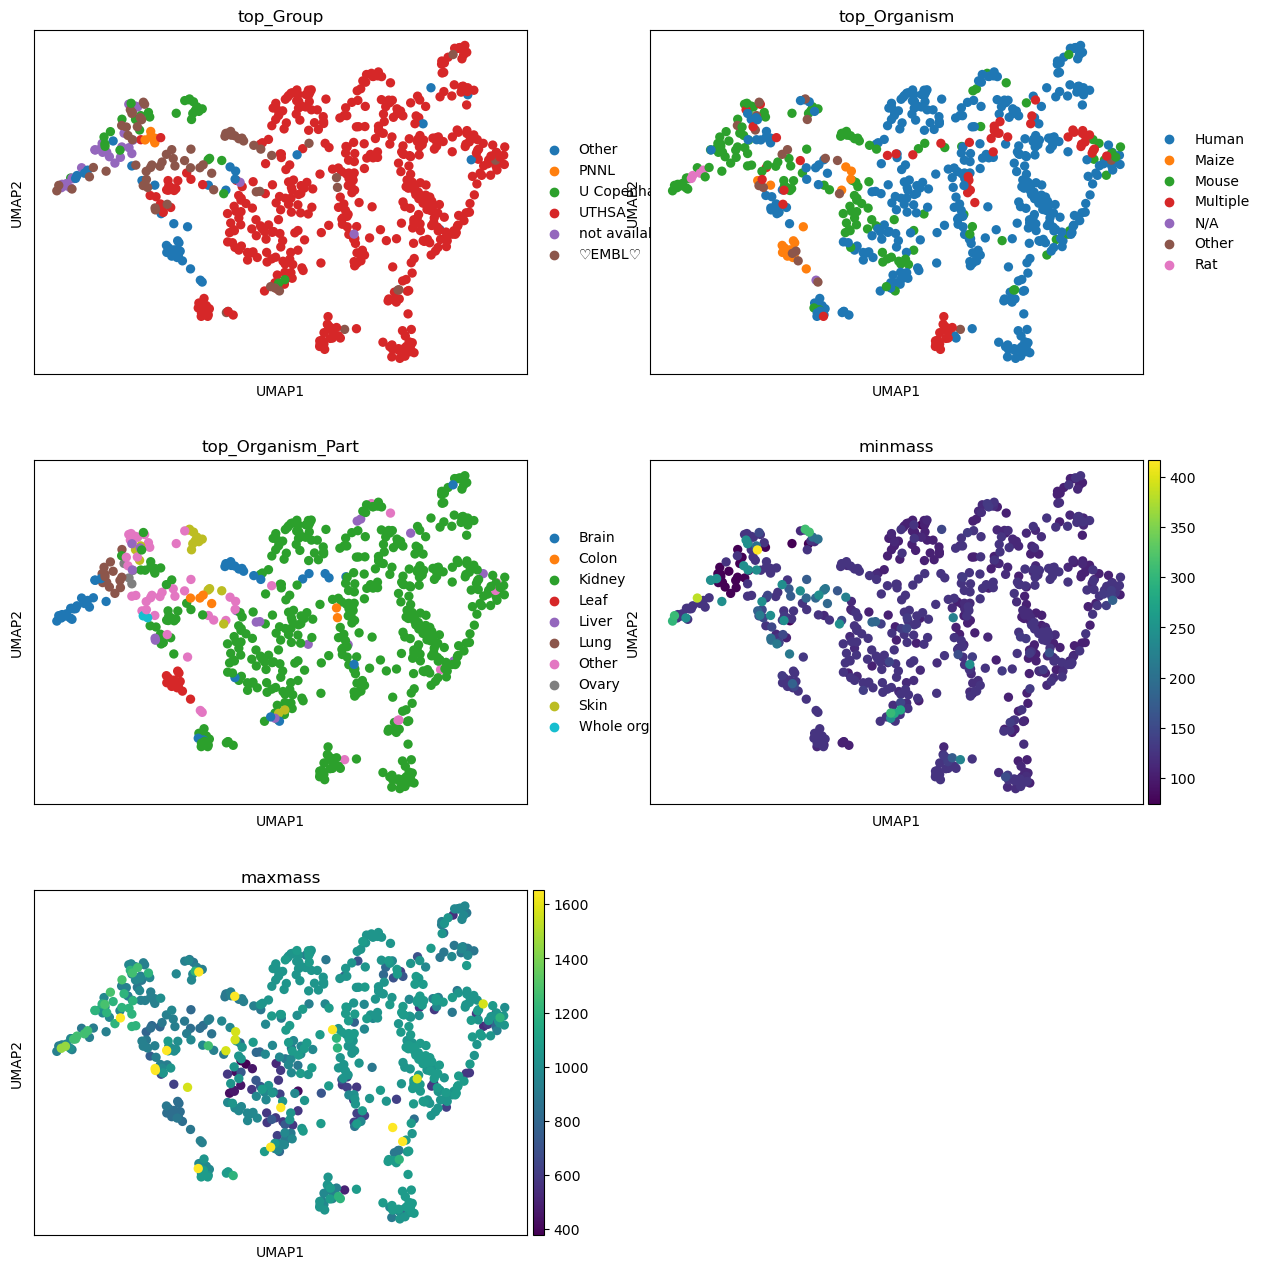

In [42]:
sc.pl.umap(adata_neg_matrix, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## MZ range

In [43]:
adata_neg_matrix_mz = adata_neg_matrix[:,adata_neg_matrix.var['mass'] < 1400]
adata_neg_matrix_mz = adata_neg_matrix_mz[:,adata_neg_matrix_mz.var['mass'] > 100]

sc.pp.pca(adata_neg_matrix_mz)
sc.pp.neighbors(adata_neg_matrix_mz, metric='cosine')
sc.tl.leiden(adata_neg_matrix_mz)
sc.tl.umap(adata_neg_matrix_mz)

utils.update_minmax_mass(adata_neg_matrix_mz)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


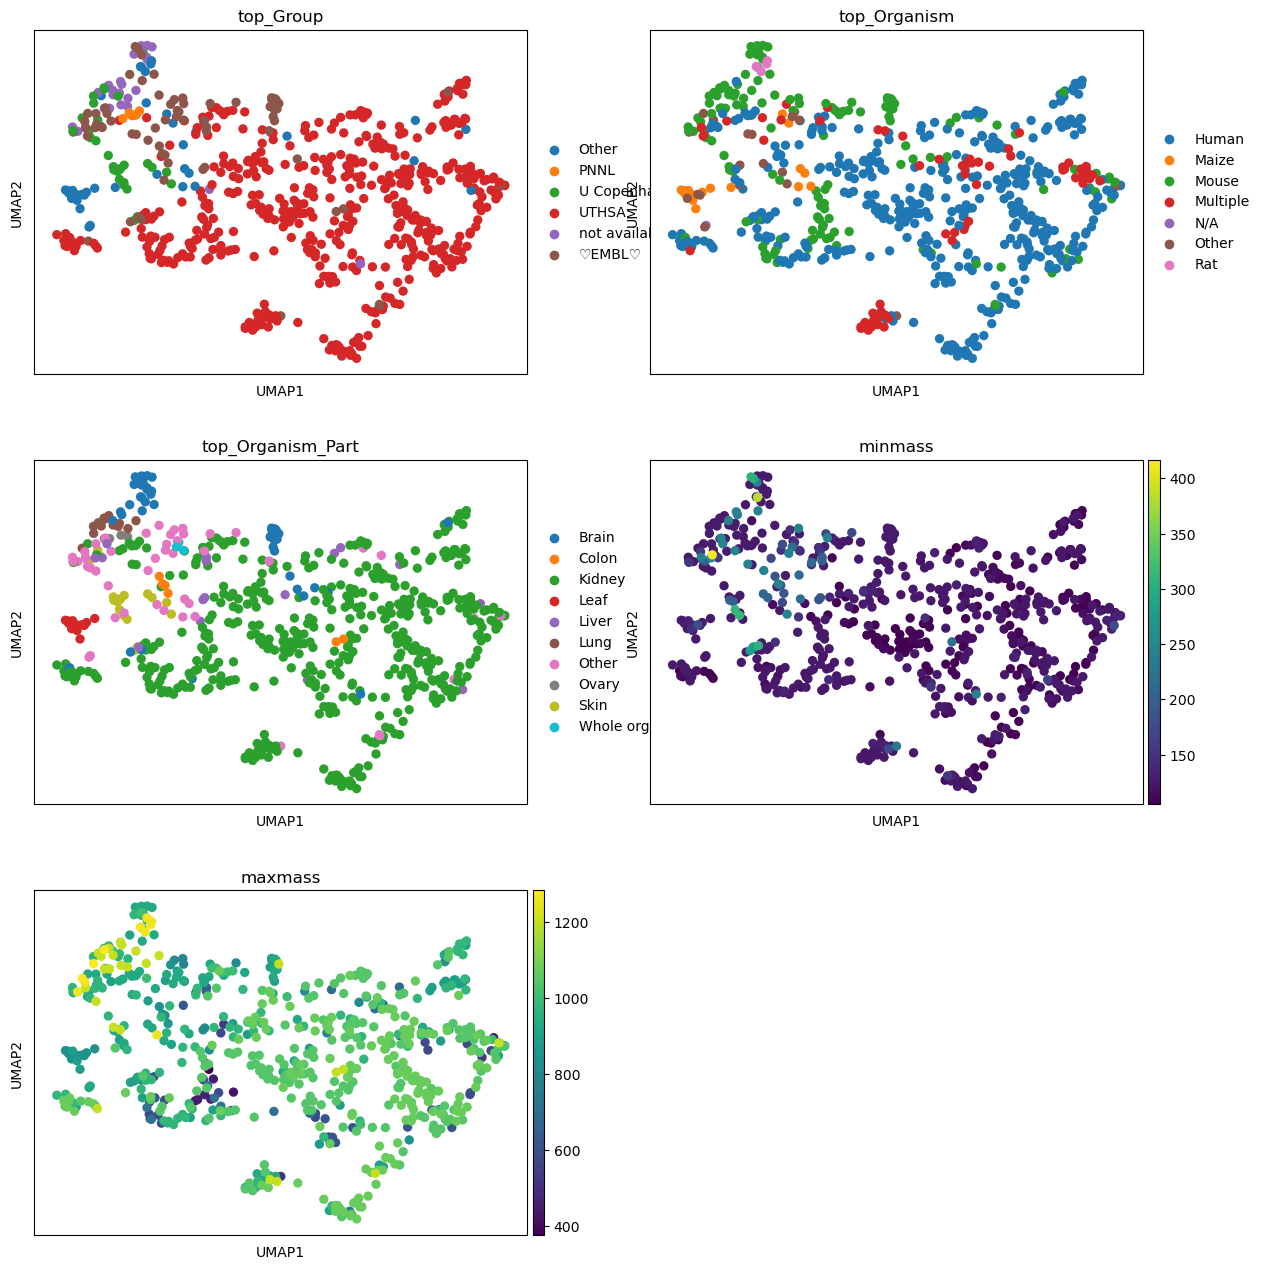

In [44]:
sc.pl.umap(adata_neg_matrix_mz, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## Select tissues

In [45]:
tissue_list = ['Brain', 'Colon', 'Epididymis', 'Kidney', 'Liver', 'Lung', 'Ovary', 'Skin']


adata_neg_matrix_mz_tissue = adata_neg_matrix_mz[adata_neg_matrix_mz.obs['top_Organism_Part'].isin(tissue_list), :]
sc.pp.filter_genes(adata_neg_matrix_mz_tissue, min_cells=5)

sc.pp.pca(adata_neg_matrix_mz_tissue)
sc.pp.neighbors(adata_neg_matrix_mz_tissue, metric='cosine')
sc.tl.leiden(adata_neg_matrix_mz_tissue)
sc.tl.umap(adata_neg_matrix_mz_tissue)

utils.update_minmax_mass(adata_neg_matrix_mz_tissue)

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


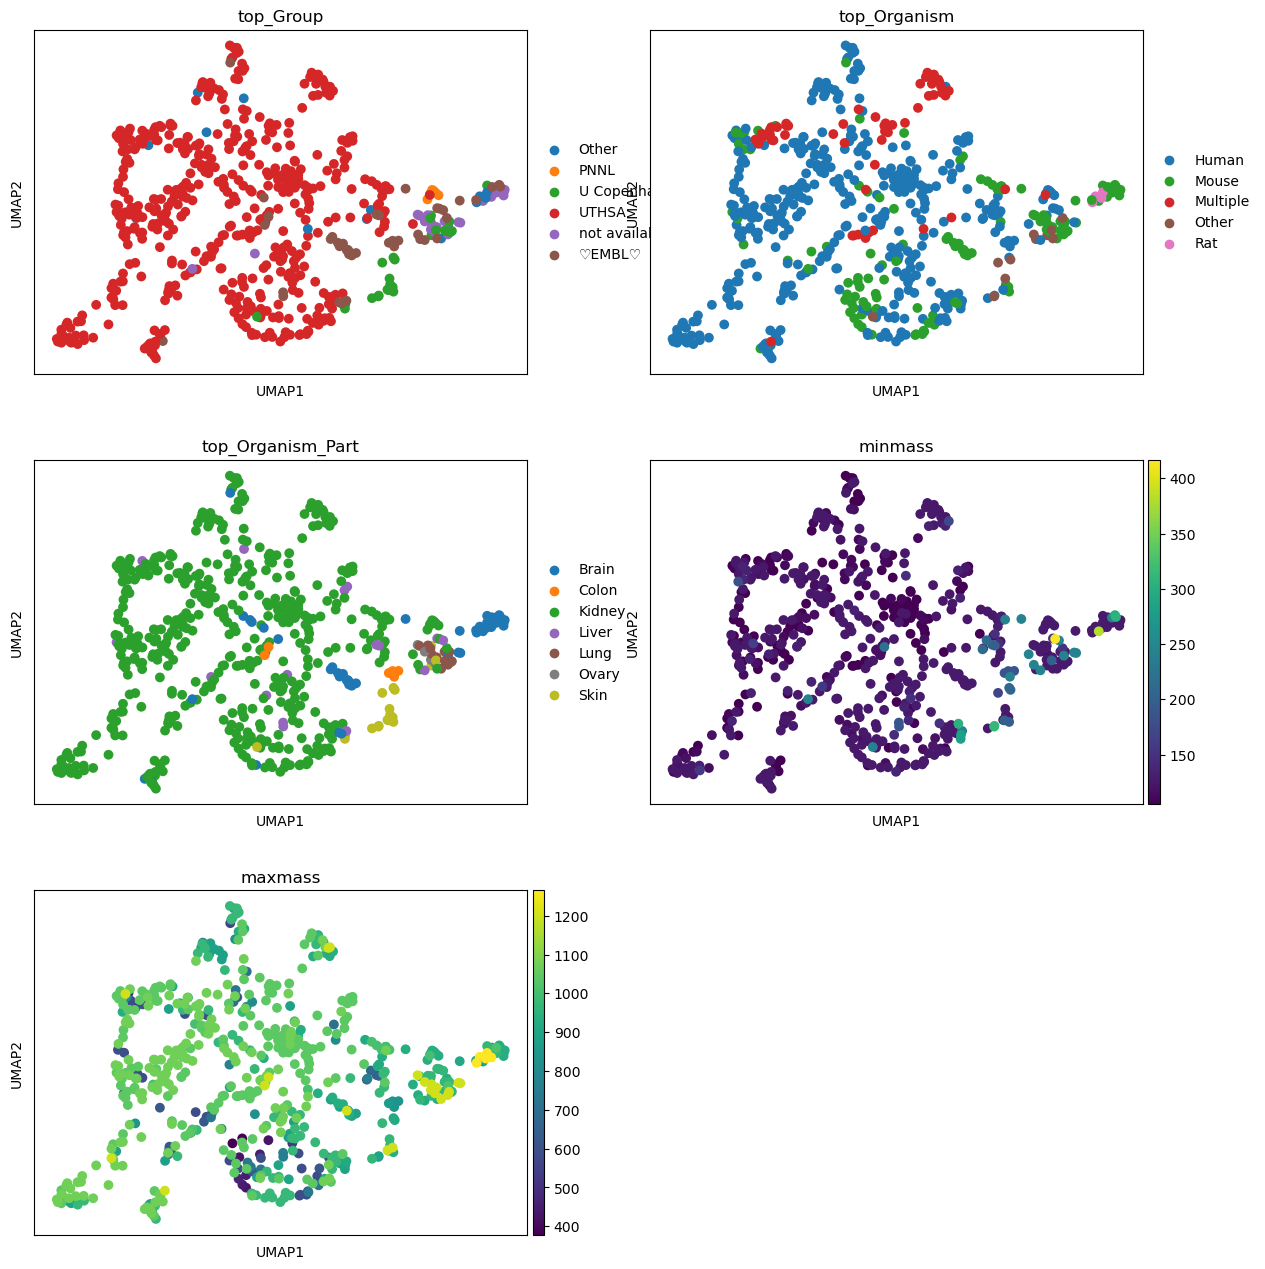

In [46]:
sc.pl.umap(adata_neg_matrix_mz_tissue, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

## Tissue prototyping

In [48]:
tissue_mol_freq_neg = {}
tissue_top_datasets_neg = {}

mol_freq_cutoff = 0.1 # Initial: 0.1
top_ds_cutoff = 0.2 # Initial: 0.2
mol_freq2_cutoff = 0.2

### Brain

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


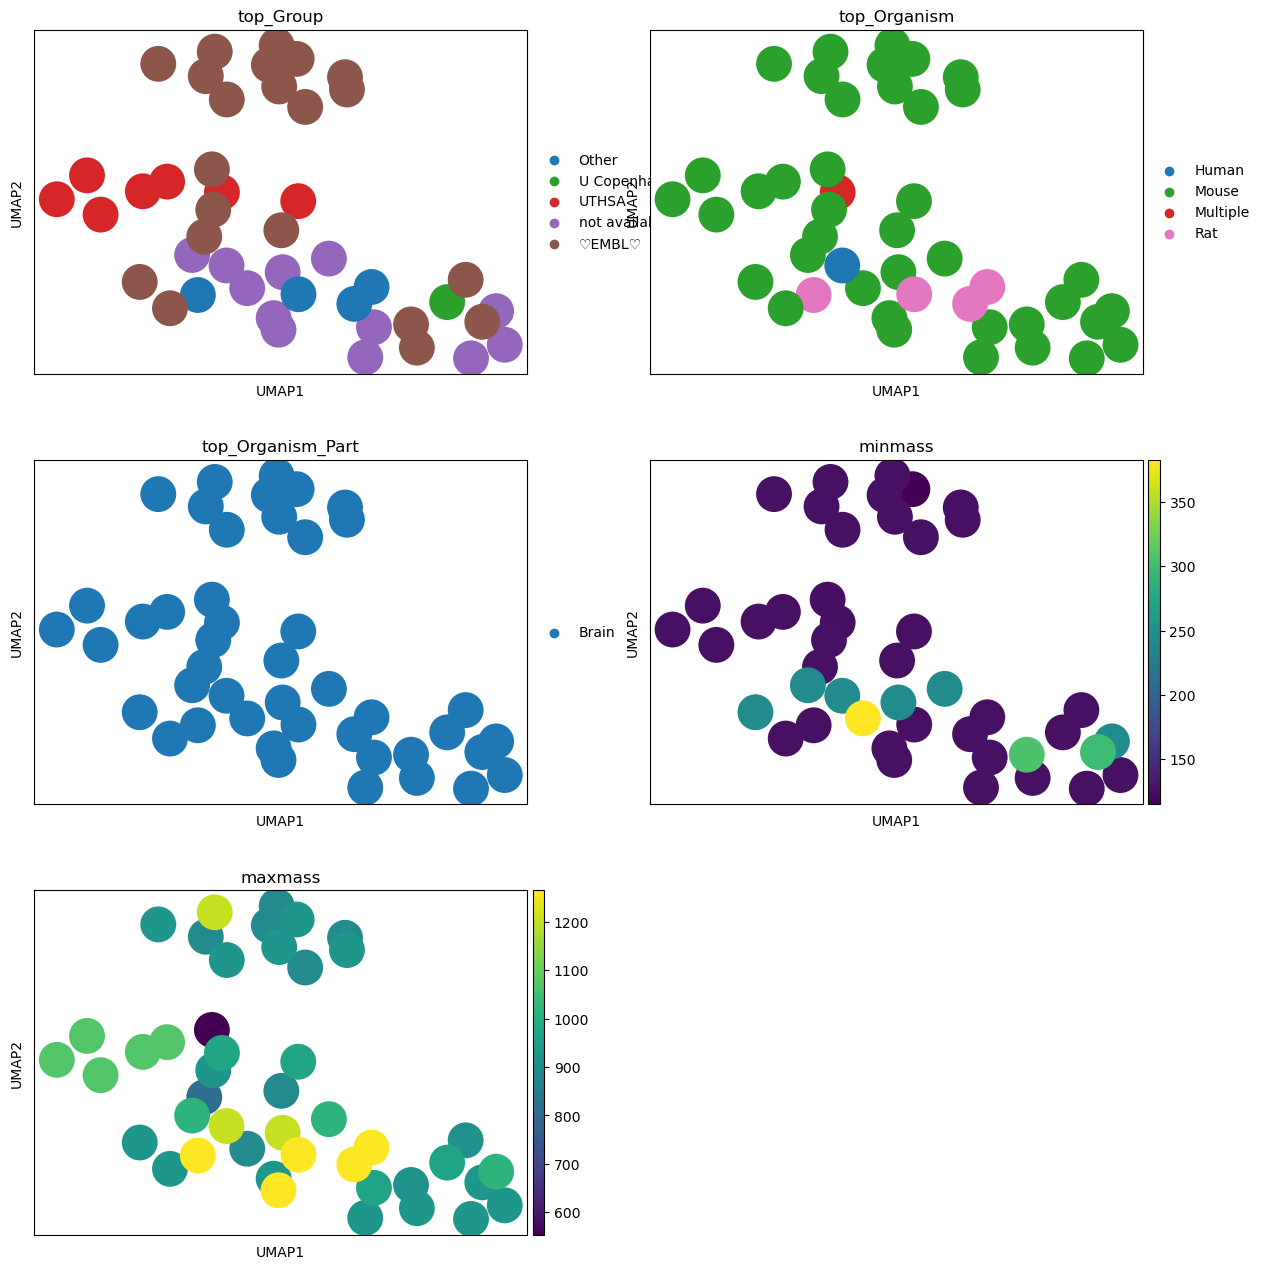

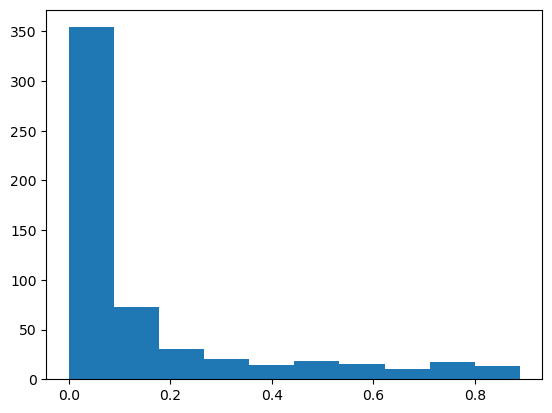

2021-09-27_19h51m20s    56
2021-03-22_14h42m06s    56
2017-08-18_16h00m58s    56
2017-09-14_13h43m01s    56
2016-11-18_06h01m50s    55
2017-08-08_08h49m46s    55
2021-04-14_18h06m51s    54
2021-09-27_21h29m45s    54
2017-08-15_13h02m38s    54
2017-08-15_19h13m44s    53
dtype: int64


In [49]:
tissue = 'Brain'
adat = adata_neg_matrix_mz_tissue[adata_neg_matrix_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff, mol_freq2_cutoff=mol_freq2_cutoff)
tissue_mol_freq_neg[tissue] = mol_freq2
tissue_top_datasets_neg[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_neg_{tissue}.csv'))

print(top_datasets.sort_values(ascending=False))

In [200]:
utils.annotations_list(mol_freq2.index, hmdb_v4, n=4)

C18H13NO4  -  ['Hallacridone', 'Aristolodione']
C42H82NO6P  -  ['CerP(d18:1/24:1(15Z))', 'PC(P-16:0/P-18:1(11Z))', 'PC(P-16:0/P-18:1(9Z))', 'PC(P-18:1(11Z)/P-16:0)']
C41H77O8P  -  ['PA(14:1(9Z)/24:1(15Z))', 'PA(16:0/22:2(13Z,16Z))', 'PA(16:1(9Z)/22:1(13Z))', 'PA(18:1(11Z)/20:1(11Z))']
C43H77O8P  -  ['PA(18:0/22:4(7Z,10Z,13Z,16Z))', 'PA(18:2(9Z,12Z)/22:2(13Z,16Z))', 'PA(18:3(6Z,9Z,12Z)/22:1(13Z))', 'PA(18:3(9Z,12Z,15Z)/22:1(13Z))']
C41H75O8P  -  ['PA(16:1(9Z)/22:2(13Z,16Z))', 'PA(18:0/20:3(5Z,8Z,11Z))', 'PA(18:2(9Z,12Z)/20:1(11Z))', 'PA(18:3(6Z,9Z,12Z)/20:0)']
C41H69O8P  -  ['PA(16:0/22:6(4Z,7Z,10Z,13Z,16Z,19Z))', 'PA(16:1(9Z)/22:5(4Z,7Z,10Z,13Z,16Z))', 'PA(16:1(9Z)/22:5(7Z,10Z,13Z,16Z,19Z))', 'PA(18:1(11Z)/20:5(5Z,8Z,11Z,14Z,17Z))']
C10H17N3O6S  -  ['Glutathione', 'Glutathionate(1-)']
C42H80NO10P  -  ['PS(18:0/18:1(9Z))', 'PS(18:1(9Z)/18:0)', 'PS(14:1(9Z)/22:0)', 'PS(16:0/20:1(11Z))']
C20H38O2  -  ['11Z-Eicosenoic acid', '11-Eicosenoic acid', 'Ethyl oleate', 'Paullinic acid']
C21H44NO6

### Colon

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


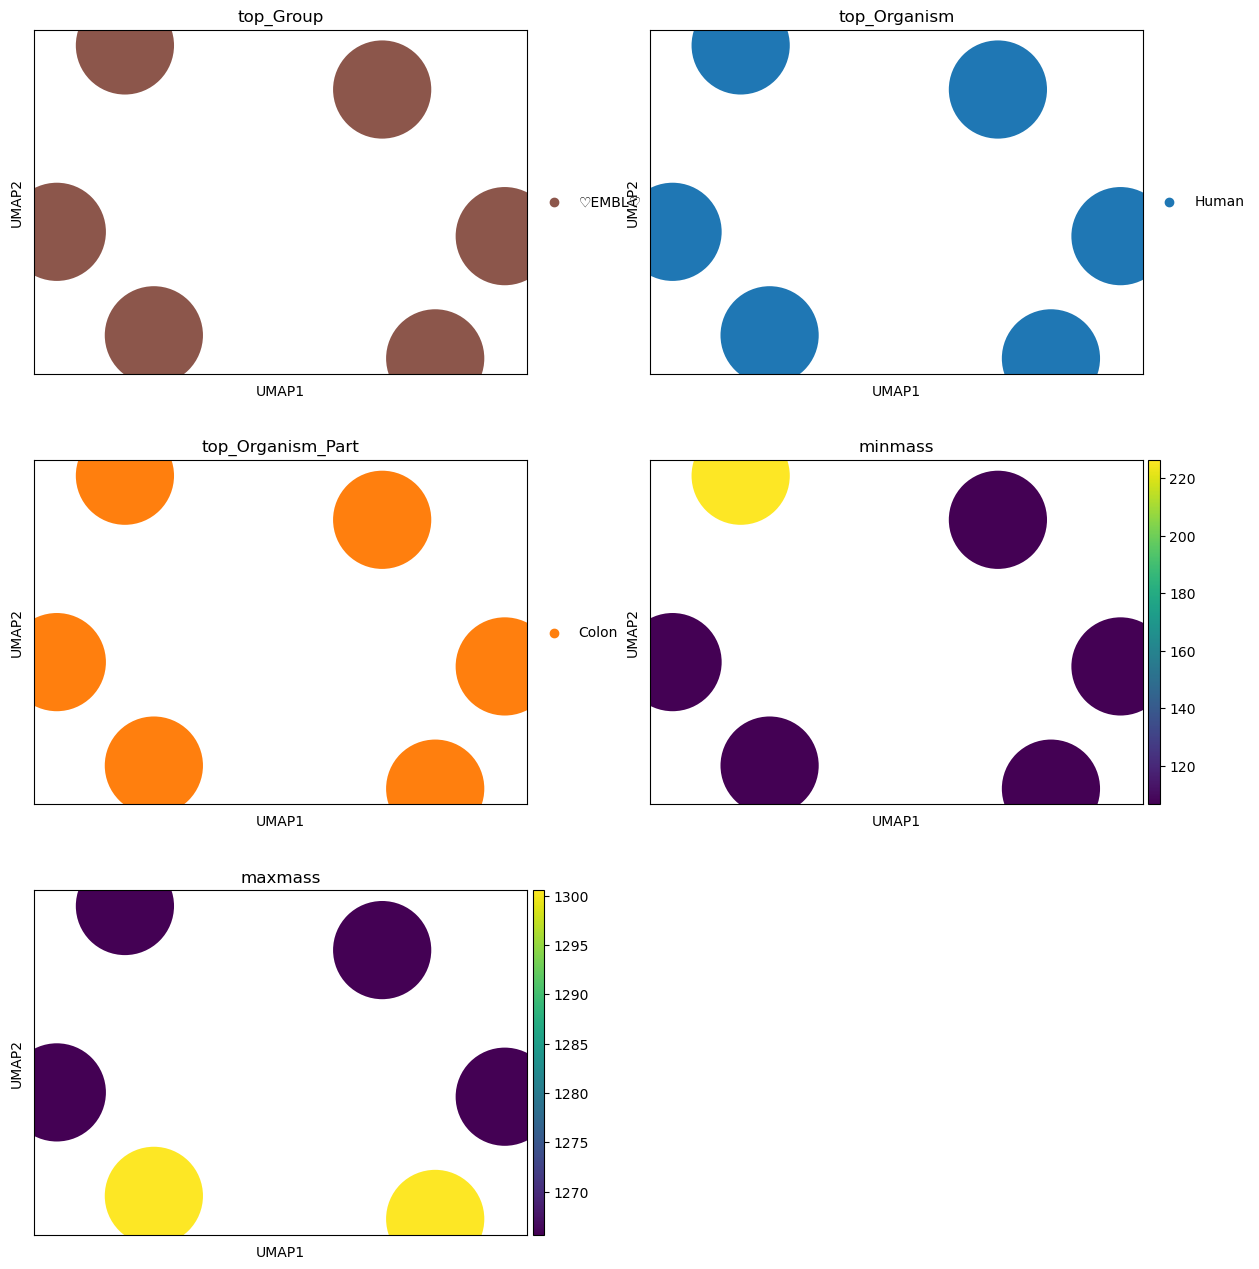

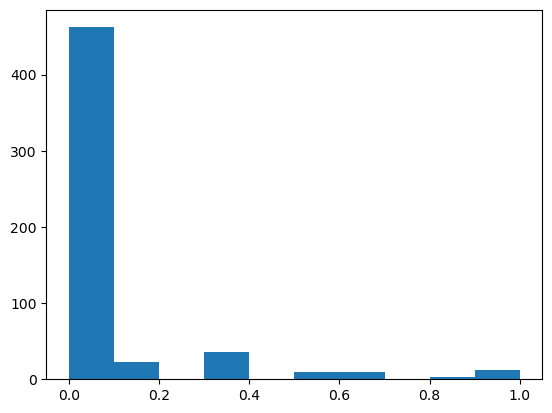

In [201]:
tissue = 'Colon'
adat = adata_neg_matrix_mz_tissue[adata_neg_matrix_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff, mol_freq2_cutoff=mol_freq2_cutoff)
tissue_mol_freq_neg[tissue] = mol_freq2
tissue_top_datasets_neg[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_neg_{tissue}.csv'))

### Kidney

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


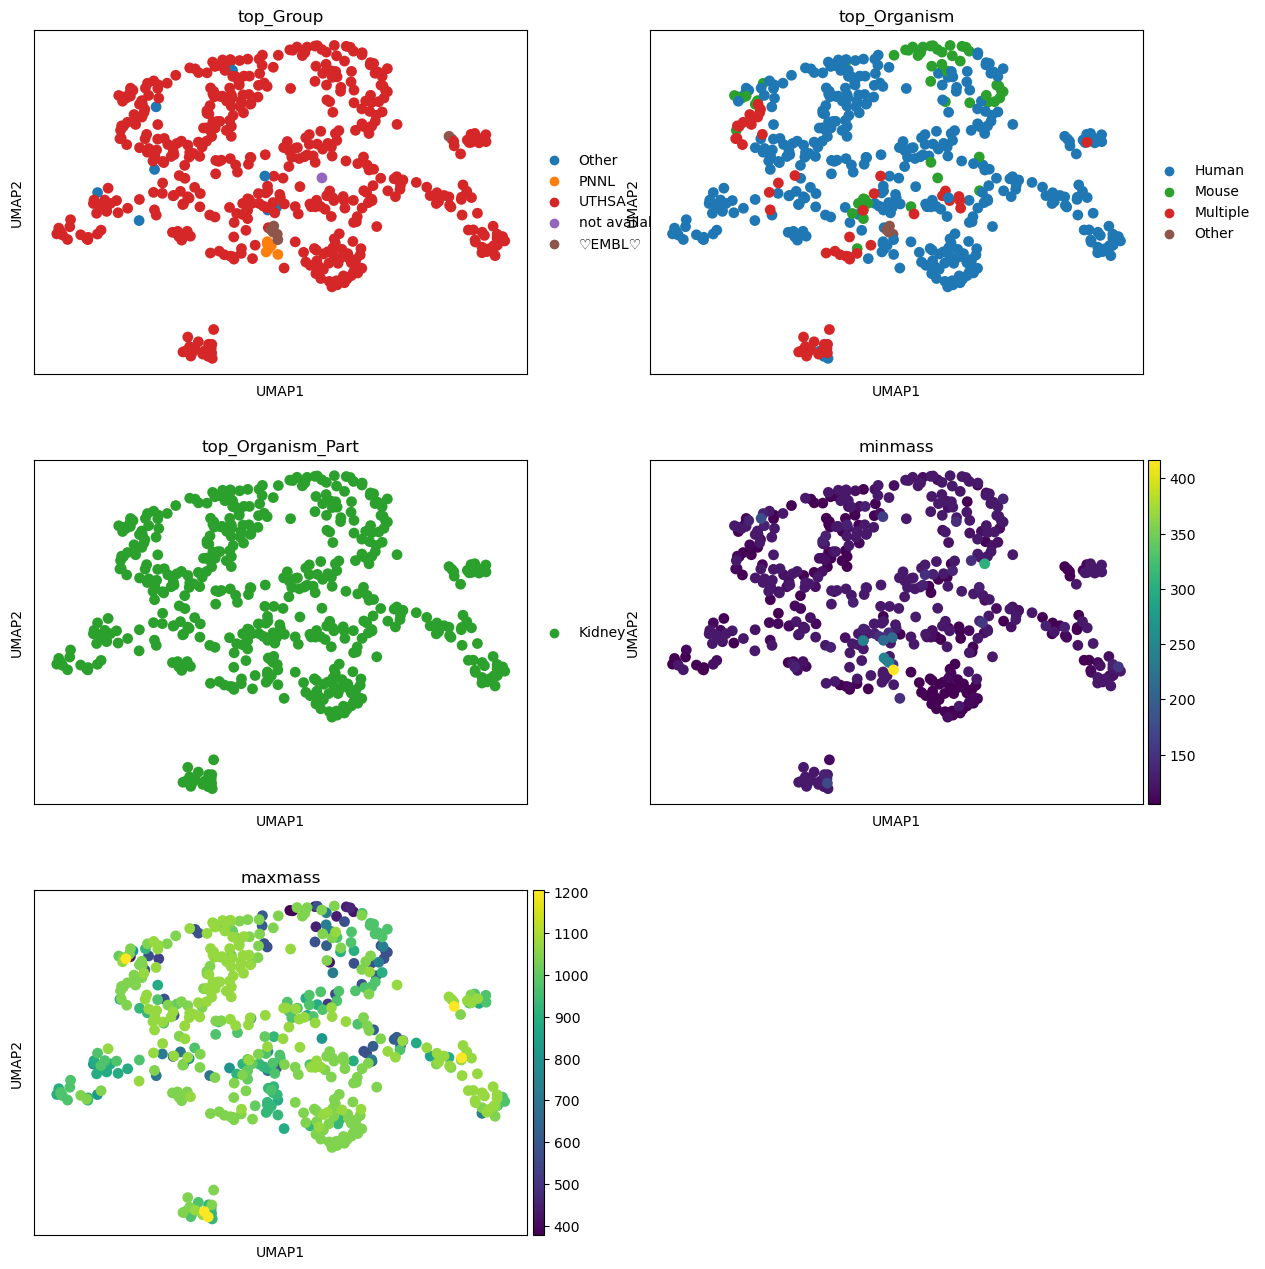

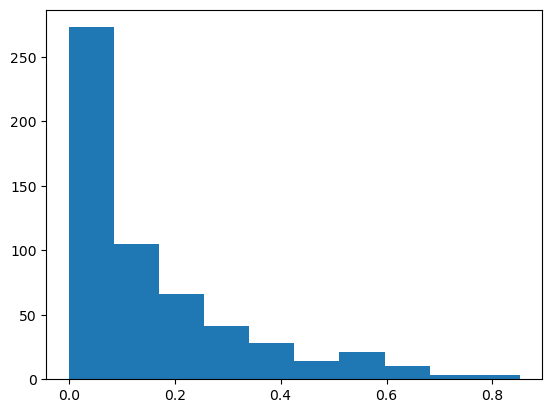

2020-12-05_14h49m21s    57
2020-12-05_14h58m17s    56
2020-12-05_14h54m27s    56
2019-05-10_20h18m39s    55
2022-06-25_19h53m12s    55
                        ..
2022-06-09_20h25m24s    48
2019-10-29_21h40m16s    48
2022-06-11_22h18m44s    48
2022-10-31_22h01m40s    48
2022-05-21_20h02m41s    48
Length: 101, dtype: int64


In [50]:
tissue = 'Kidney'
adat = adata_neg_matrix_mz_tissue[adata_neg_matrix_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff, mol_freq2_cutoff=mol_freq2_cutoff)
tissue_mol_freq_neg[tissue] = mol_freq2
tissue_top_datasets_neg[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_neg_{tissue}.csv'))

print(top_datasets.sort_values(ascending=False))

### Liver

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


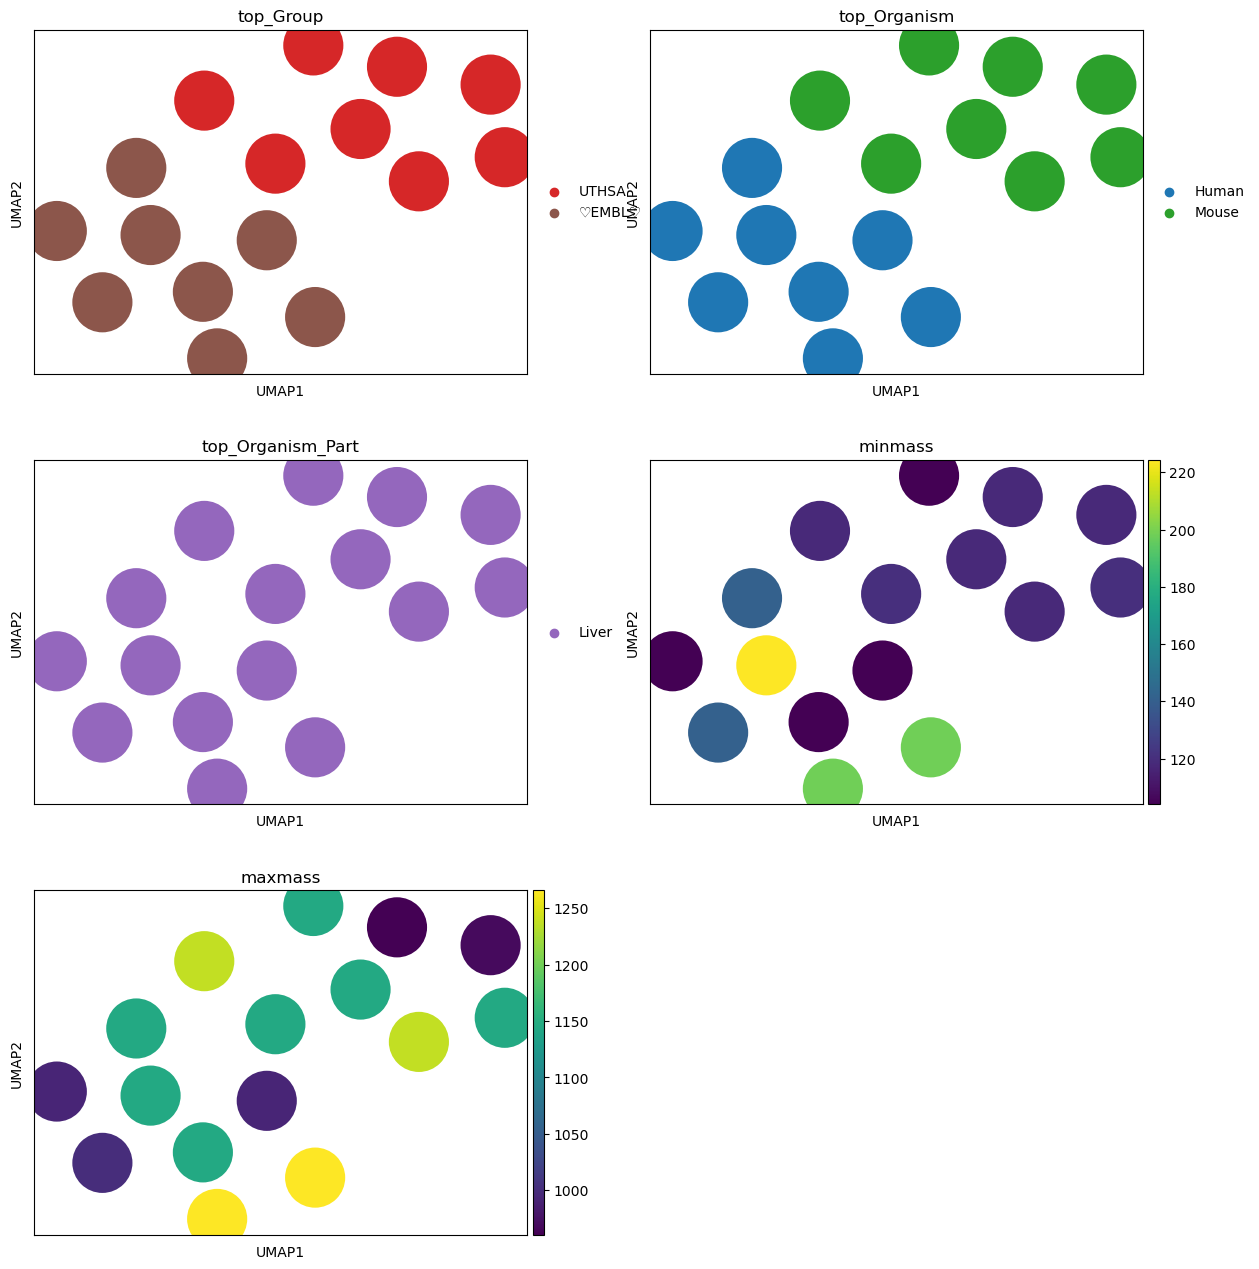

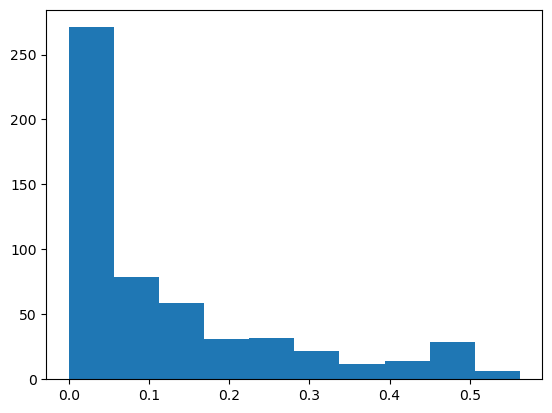

In [203]:
tissue = 'Liver'
adat = adata_neg_matrix_mz_tissue[adata_neg_matrix_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff, mol_freq2_cutoff=mol_freq2_cutoff)
tissue_mol_freq_neg[tissue] = mol_freq2
tissue_top_datasets_neg[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_neg_{tissue}.csv'))

### Lung

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


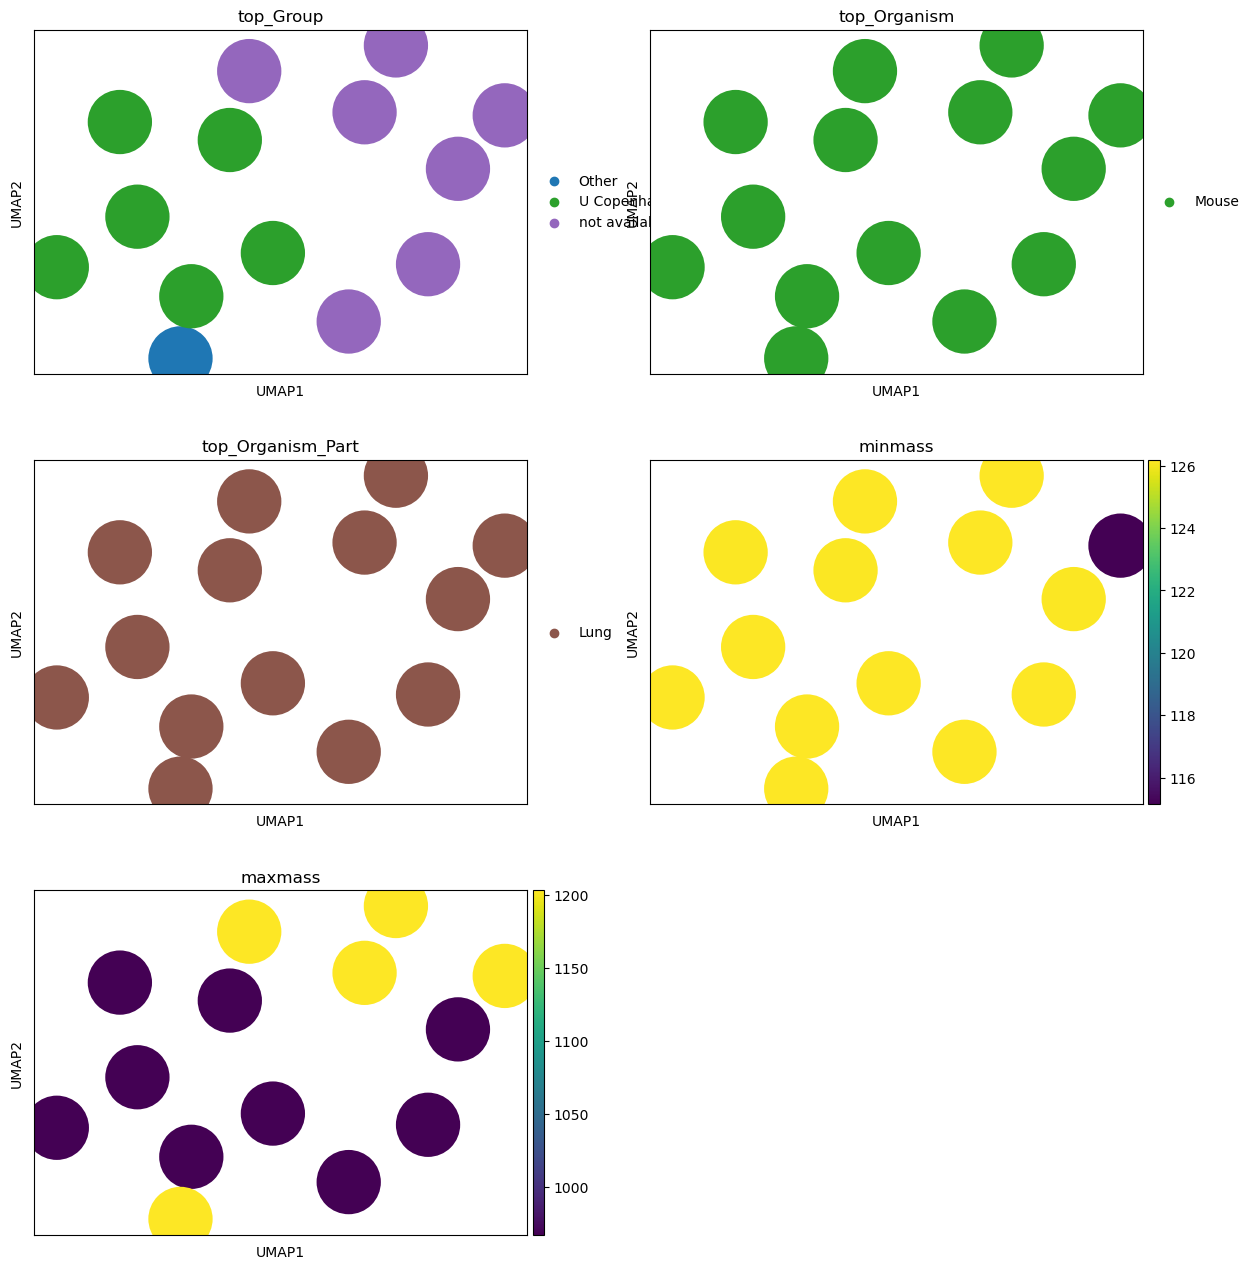

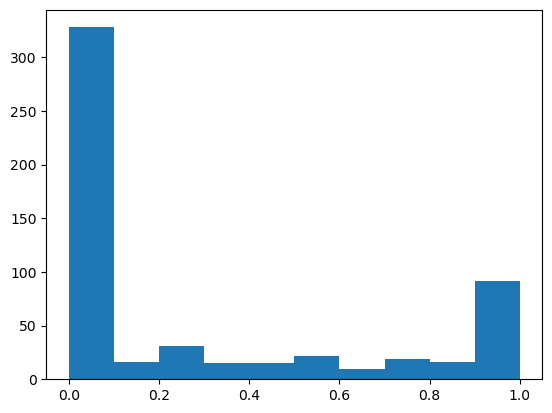

2022-05-17_15h40m15s    71
2022-03-08_16h44m33s    71
2022-03-07_11h16m23s    71
2022-03-04_11h13m43s    71
2022-03-02_15h56m01s    71
2022-02-28_12h37m31s    71
2022-02-22_11h06m11s    71
2022-02-14_11h58m38s    71
2019-01-17_19h54m30s    71
2018-10-31_10h26m49s    71
2018-10-18_15h53m44s    71
2018-10-16_09h53m21s    71
2018-10-12_09h25m16s    71
2018-10-12_09h21m15s    71
dtype: int64


In [51]:
tissue = 'Lung'
adat = adata_neg_matrix_mz_tissue[adata_neg_matrix_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff, mol_freq2_cutoff=mol_freq2_cutoff)
tissue_mol_freq_neg[tissue] = mol_freq2
tissue_top_datasets_neg[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_neg_{tissue}.csv'))

print(top_datasets.sort_values(ascending=False))

### Ovary

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


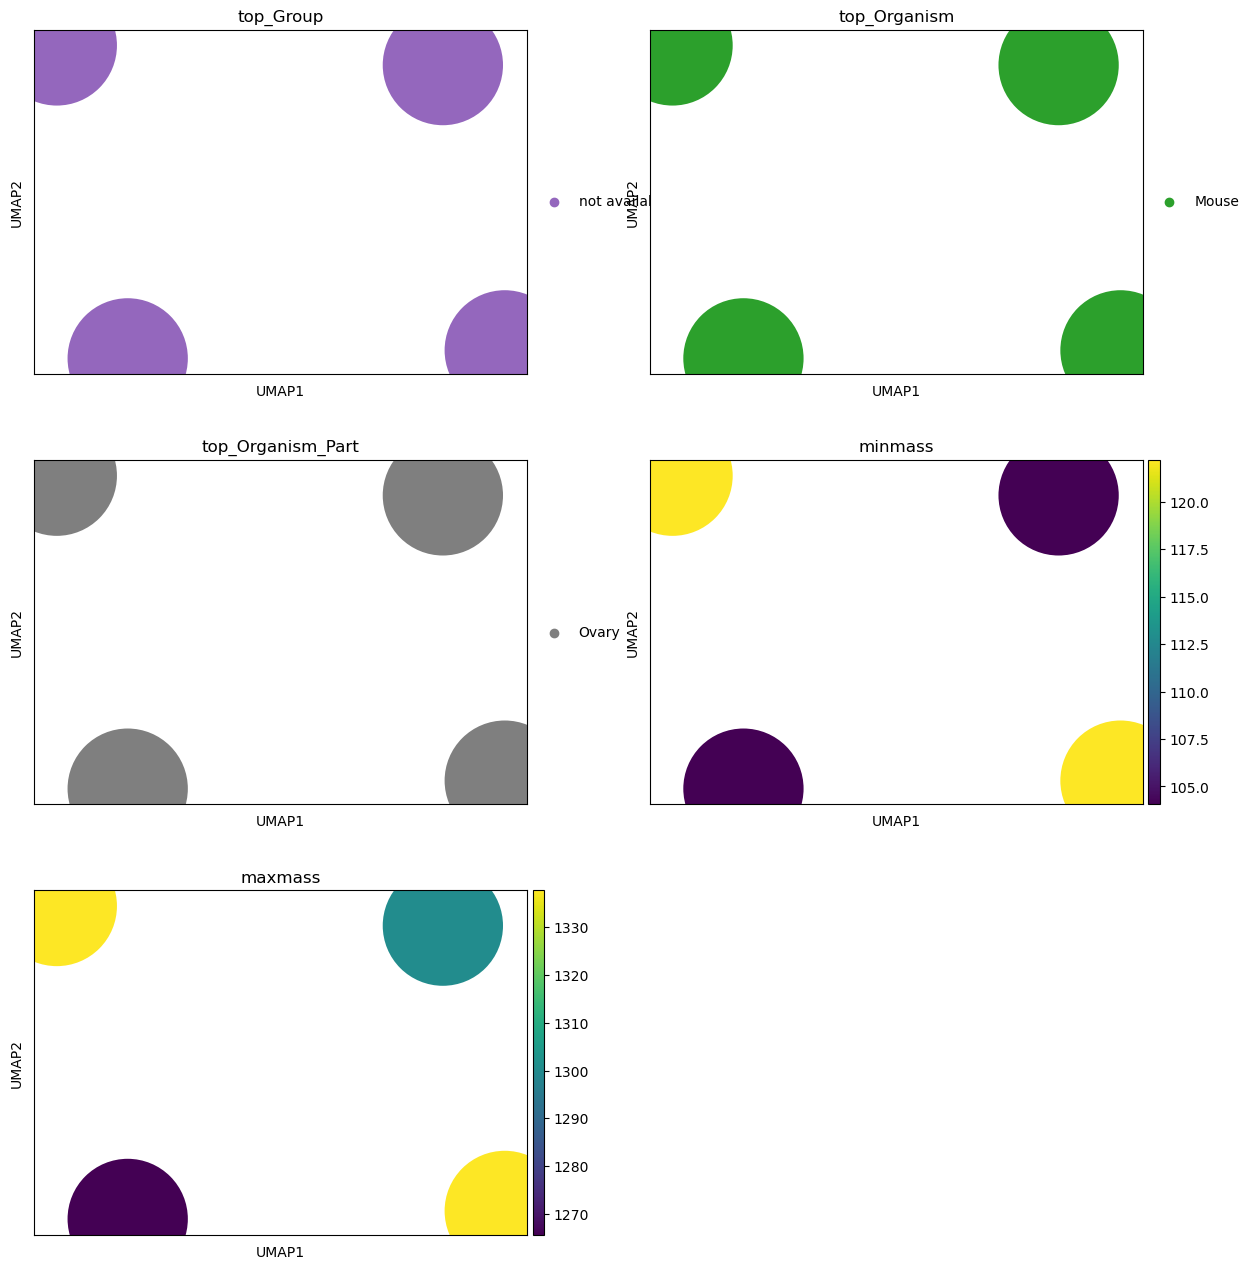

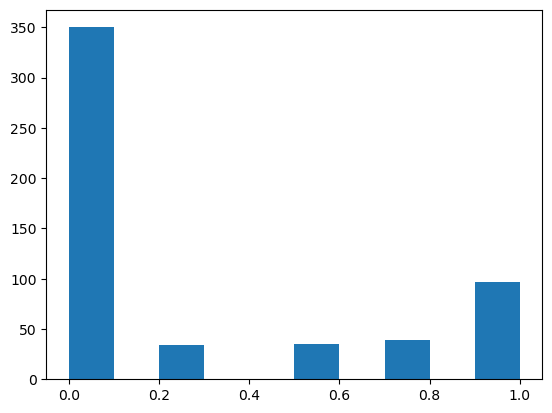

In [205]:
tissue = 'Ovary'
adat = adata_neg_matrix_mz_tissue[adata_neg_matrix_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff, mol_freq2_cutoff=mol_freq2_cutoff)
tissue_mol_freq_neg[tissue] = mol_freq2
tissue_top_datasets_neg[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_neg_{tissue}.csv'))

### Skin

/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/trose/.conda/envs/metabolomics/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


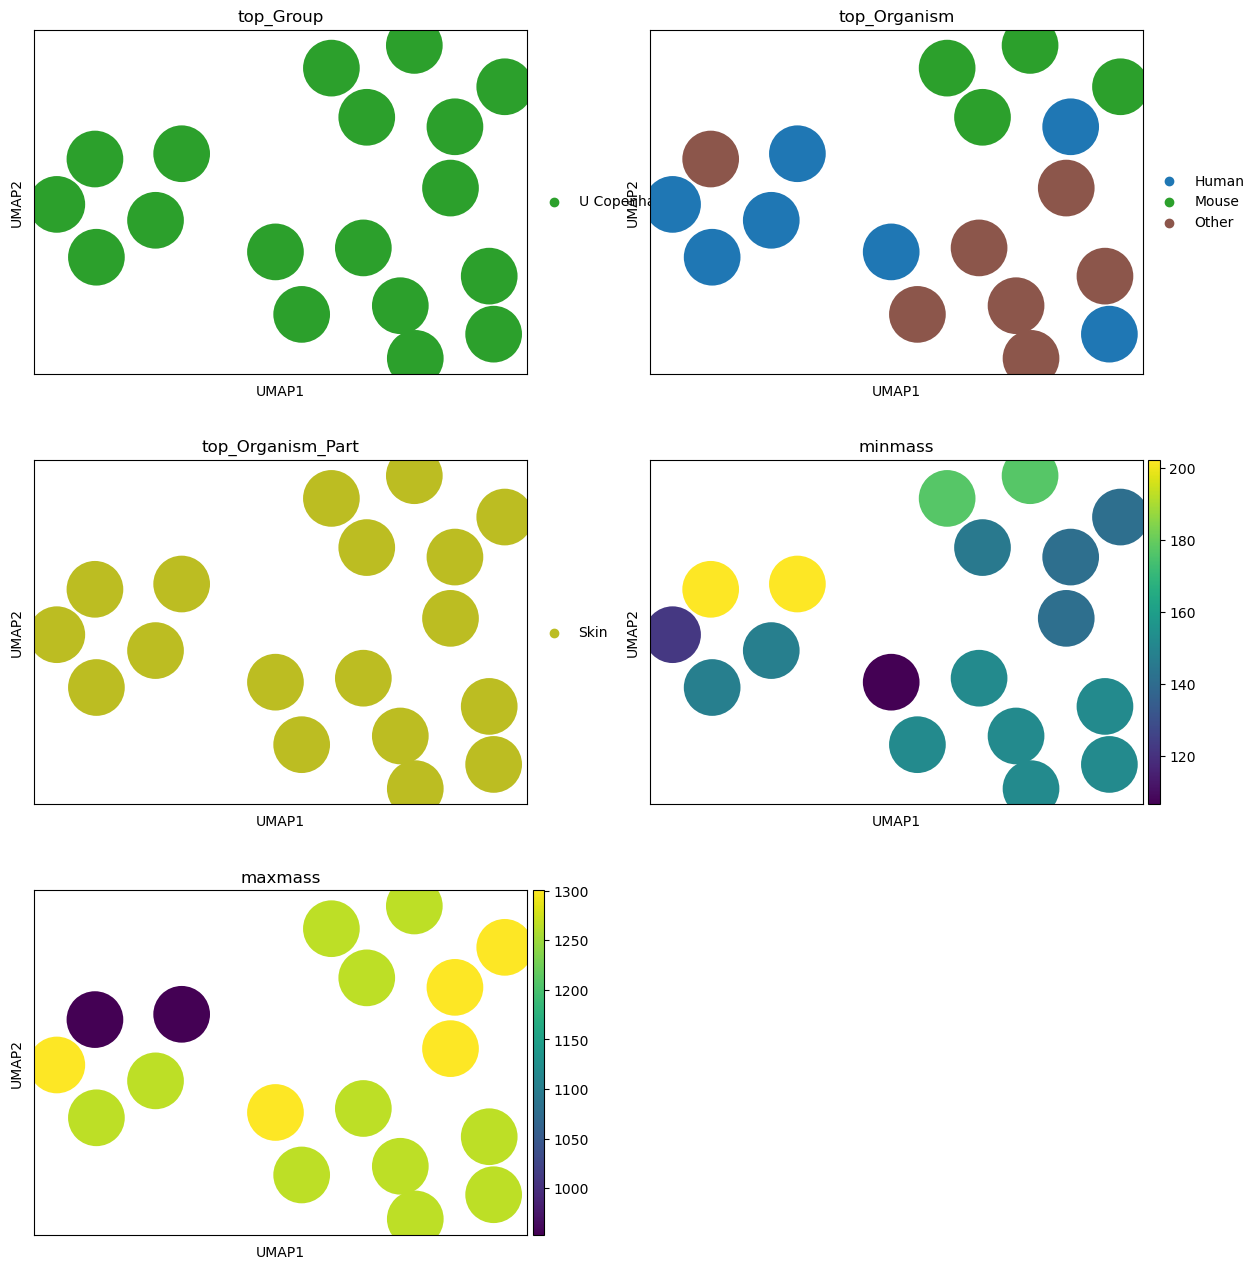

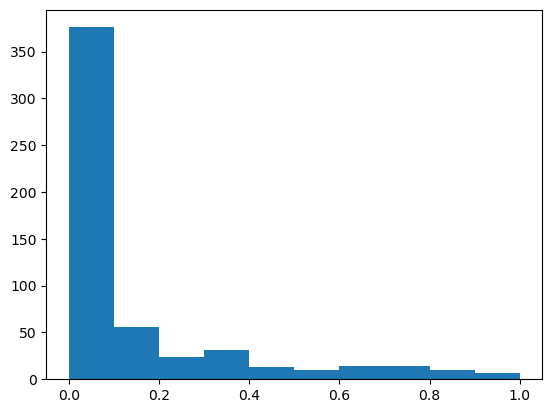

In [206]:
tissue = 'Skin'
adat = adata_neg_matrix_mz_tissue[adata_neg_matrix_mz_tissue.obs['top_Organism_Part']==tissue, :]

sc.pp.pca(adat)
sc.pp.neighbors(adat, metric='cosine')
sc.tl.leiden(adat)
sc.tl.umap(adat)

utils.update_minmax_mass(adat)

sc.pl.umap(adat, color=['top_Group', 'top_Organism', 'top_Organism_Part', 'minmass', 'maxmass'], 
           ncols=2)

mol_freq2, top_datasets, _ = utils.tissue_prototyping(adat, mol_freq_cutoff=mol_freq_cutoff, top_ds_cutoff=top_ds_cutoff, mol_freq2_cutoff=mol_freq2_cutoff)
tissue_mol_freq_neg[tissue] = mol_freq2
tissue_top_datasets_neg[tissue] = top_datasets

pd.DataFrame(mol_freq2.index).to_csv(os.path.join(enrichment_dir, f'features_neg_{tissue}.csv'))

## Tissue similarity

In [207]:
freq_tab = pd.DataFrame(tissue_mol_freq_neg).transpose()
freq_tab[freq_tab.isna()] = 0

In [208]:
sim_tab = pd.DataFrame(pairwise_kernels(freq_tab, metric='cosine'), index=freq_tab.index, columns=freq_tab.index)

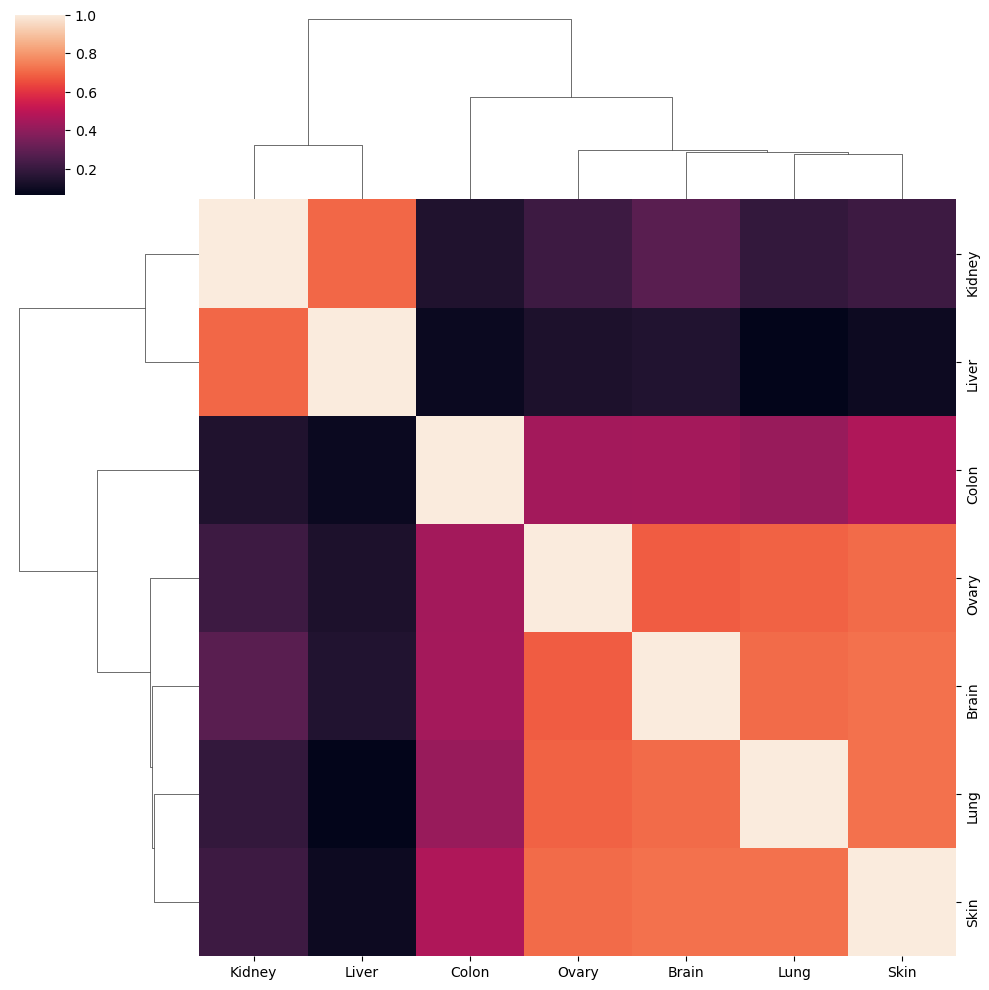

In [209]:
sns.clustermap(sim_tab)

## Network

In [210]:
tmp_sim_tab = sim_tab.copy()
tmp_sim_tab[tmp_sim_tab<0.5] = 0
g = nx.from_pandas_adjacency(tmp_sim_tab)
g.remove_edges_from(nx.selfloop_edges(g))

In [211]:
pos = nx.spring_layout(g, k=1.3)

/tmp/ipykernel_82/3020464191.py:9: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm)


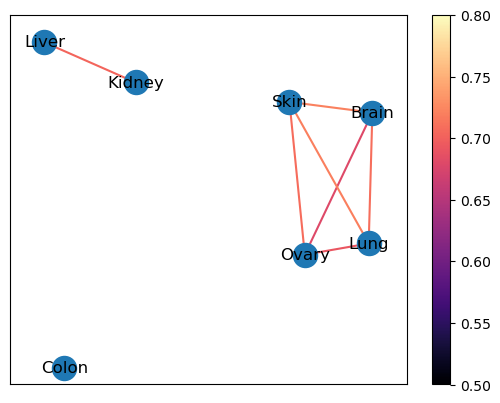

In [212]:
cm = plt.get_cmap('magma')
edge_weights = [d['weight'] for u, v, d in g.edges(data=True)]
vmin=0.5
vmax=0.8
nx.draw_networkx_edges(g, pos=pos, edge_color=edge_weights, edge_cmap=cm, width=1.5, edge_vmin=vmin, edge_vmax=vmax)
nx.draw_networkx_nodes(g, pos=pos)
nx.draw_networkx_labels(g, pos=pos)
sm = plt.cm.ScalarMappable(cmap=cm, norm=plt.Normalize(vmin=vmin, vmax=vmax))
plt.colorbar(sm)

plt.show()

In [ ]:
C48H91NO8

In [213]:
tissue_top_datasets_neg['Brain'].sort_values()

2017-08-15_19h13m44s    53
2021-04-14_18h06m51s    54
2021-09-27_21h29m45s    54
2017-08-15_13h02m38s    54
2016-11-18_06h01m50s    55
2017-08-08_08h49m46s    55
2021-09-27_19h51m20s    56
2021-03-22_14h42m06s    56
2017-08-18_16h00m58s    56
2017-09-14_13h43m01s    56
dtype: int64

In [ ]:
tissue_mol_freq_neg['Brain']